In [ ]:
# Dataset processing (calculating occurrence frequency where s4s/=0, putting into multidimensional bins)
# Processing whole dataset as one, and seasons separately. Also processing year by year
# Data on normal lat-lon coords OR lat-LT coords, OR alt-lat-LT (but here it calculates no of occs rather than occ freq since there is no altitude data where Es are not detected)
# Uses bins equiv to WACCM bins OR can turn on fivedegbins switch to use 5x5 deg lat lon bins (this is what I use for the paper)
# Original data has already filtered for Es. Where Es are detected, hmEs and s4s exist, else they are NaNs. So my processing says where its not NaN, count as Es 

#Section contents for below:
    # ---Run these bits before any data processing to get everything set up -----------------------------------------
    # '5 degree bins switch' : turn on to use 5 degree bins set by 'Defining 5 Degree Bins' section
                             # or turn off to use lat/lon bins defined by 'Defining Lat Bins' and 'Defining Lon Bins' sections below
    # 'Open WACCM dataset' : open WACCM dataset to pull out bin info
    # 'Defining Lat Bins'
    # 'Defining Lon Bins'
    # 'Defining 5 Degree Bins'
    # 'Defining Altitude Bins'
    # 'Defining LT Bins'
    # 'Load magnetic gridlines for plot'
    # 'COSMIC Data Loading (Lat-Lon, 2006-2019)' : load data sent from David
    # 'Local Time Conversion'  : calculating local_times for use in processing on local time grid
    # --- Processing on a lat-lon grid --------------------------------------------------------------------------------
    # 'COSMIC Data Processing: Occ Freq (lat-lon)' : processing data for whole ds (2006-2019) or subset of years (I'm using 2007-2009 & 2013)
    # 'COSMIC Data Processing: Occ Freq (lat-lon), Individual yrs' : processing data for each year separately
    # 'COSMIC Data Processing: Occ Freq (lat-lon), Seasons' : processing data for each season separately
    # 'COSMIC Data Processing: Occ Freq (lat-lon), Seasons - INDIVIDUAL YRS' : processing each year and season separately, so that the standard deviation can be calculated below
    # 'COSMIC Data Processing: Inter-Year Standard Deviations (lat-**lon**) for each season' : Calculating std devs of occ freqs for each season, between set of years specified
    # --- Equivalent to above but processing on a lat-local time grid --------------------------------------------------
    # 'COSMIC Data Processing: Occ Freq (lat-LT), Seasons'
    # 'COSMIC Data Processing: Occ Freq (lat-LT), Seasons - INDIVIDUAL YRS'
    # 'COSMIC Data Processing: Inter-Year Standard Deviations (lat-**lon**) for each season'
    # --- Processing on an altitude-latitude-local time grid (Calculating the number of occurences not occurence freq, since no altitude info where Es not identified) 
    # 'COSMIC Data Processing: Occ Freq (ALT-lat-LT), Seasons'
    # ------------------------------------------------------------------------------------------------------------------


'''Information from David Themens <d.r.themens@bham.ac.uk>:
    
The variables in the file are:
 
Latitude: Latitude of the S4_Max point
Longitude: Longitude of the S4_Max point
hmEs: Height of S4_Max (km)
Julian_date: Julian date-formatted time of the occultation (I started coding in IDL, which uses Julian Date heavily, you can convert it to any other time format easily)
s4s: S4_Max
 
This includes all occultations, even those that did not have Sporadic-E. I have here set s4s to NaN when it did not meet the criteria for Sporadic-E. 
 
Sporadic_E was only assigned under the following conditions:
 
•	Only altitudes between 70km and 150km were considered
•	S4_Max > 0.2
•	Standard Deviation of S4 over the full range < 0.11
•	The altitude range over which S4 > 0.2 is less than 10km wide in altitude (if multiple Es layers are present, this condition will, unfortunately, flag the whole thing as not being Sporadic-E, as I did not require the range to be contiguous)
 
All of the above conditions are as per Christina Arras' work on the subject (reference links in the AGU poster I sent across before). 
 
If no Sporadic-E is detected, the Latitude, Longitude, and time are selected as those that correspond to 110km altitude. S4 in this case was calculated using  a ~2km-wide window.

If the occultation does not reach at least 125km, I set everything to NaN since the coverage of the observation would not cover a sufficient range to conclude whether Es was or wasn't present above. 
This wasn't common with COSMIC, but it happened pretty regularly with some of the other RO satellites.
'''



In [1]:
#Master list of packages - not all of these are used in the code below. Should delete any that are unused .......

import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
import dask.array as da
import dask.dataframe as dd
import dask
%matplotlib inline 
import matplotlib.gridspec as gridspec
#import line_profiler
#%load_ext line_profiler


/tmp/ipykernel_678567/1136095216.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# 5 degree bins switch

In [2]:
fivedegbins = 1

# Open WACCM dataset

In [3]:
################################################################################
# Open WACCM dataset to define bins
################################################################################

# arrays are sliced between chosen range (~90-130km) indices 42-60, 19 levels

file1name='Nc_Files/SpE_Output/Wuhu_IonTr_run_SpE_Output_Dec-Feb.nc' 
wds = xr.open_dataset(file1name)

wds_lat = wds['lat']
wds_lon = wds['lon']

lev_sl = wds['lev_sl']
Zavg_sl = wds.variables['Zavg_sl'] 

altavg = wds['altavg']

altavg_sl = wds['altavg_sl']
# altavg_sl.values # array([131.1492157 , 126.73989868, 122.75083923, 119.16303253,
#        115.95503998, 113.10031128, 110.56510162, 108.3082428 ,
#        106.28289795, 104.44081879, 102.7361145 , 101.12830353,
#         99.58457184,  98.0800705 ,  96.59645081,  95.12115479,
#         93.64645386,  92.16801453,  90.6837616 ])


print('    Array lev = ' + str("%.1e" % lev_sl[-1] ) + 'hPa : ' + str("%.1e" % lev_sl[0] ) + 'hPa'
           + ' (Z3 approx ' + str("%.0f" % Zavg_sl[-1]) + '-' + str("%.0f" % Zavg_sl[0] ) + 'km' + ',' 
           + ' Alt approx ' + str("%.0f" % altavg_sl[-1]) + '-' + str("%.0f" % altavg_sl[0] ) + 'km' + ')' )

    Array lev = 1.3e-03hPa : 1.5e-05hPa (Z3 approx 89-129km, Alt approx 90-131km)


# Defining Lat Bins

In [4]:
################################################################################
# Lat bins
################################################################################

# 96 bins
lat_bin_midpoints = wds_lat.values

lat_bin_widths = np.diff(lat_bin_midpoints)
lat_average_bin_width = np.mean(lat_bin_widths)

lat_bin_edges = np.zeros(len(lat_bin_midpoints)+1)
lat_bin_edges[0] = lat_bin_midpoints[0] - lat_average_bin_width/2
lat_bin_edges[-1] = lat_bin_midpoints[-1] + lat_average_bin_width/2
lat_bin_edges[1:-1] = (lat_bin_midpoints[:-1] + lat_bin_midpoints[1:]) / 2

lat_num_bins = len(lat_bin_midpoints)



# # ##Print the results
# print("Lat Bin Edges (Lower and Upper):")
# for i in range(len(lat_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{lat_bin_edges[i]}, {lat_bin_edges[i + 1]}]")

# print("\nLat Bin Midpoints:")
# for i in range(len(lat_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {lat_bin_midpoints[i]}")

# print("\nLat Bin Widths:", lat_bin_widths)
# print(f"Lat Average Bin Width: {lat_average_bin_width:.6f} degrees")
# print(f"Lat Number of Bins: {lat_num_bins}")


# # Lat Average Bin Width: 1.894737 degrees
# # Lat Number of Bins: 95

# Defining Lon Bins

In [5]:
# ################################################################################
# # Lon bins -180 -> 180
# ################################################################################

# Updated value for a range of -180 to +180 degrees
lon_upper_edge_last_bin = 180.0
lon_bin_edges = np.append(np.arange(-180.0, 180.0, 2.5), lon_upper_edge_last_bin)
lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2

# Other calculations (width, number of bins, etc.) remain the same
lon_bin_widths = np.diff(lon_bin_edges)
lon_average_bin_width = np.mean(lon_bin_widths)
lon_num_bins = len(lon_bin_midpoints)


# print("Lon Bin Edges (Lower and Upper):")
# for i in range(len(lon_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{lon_bin_edges[i]}, {lon_bin_edges[i + 1]}]")

# print("\nLon Bin Midpoints:")
# for i in range(len(lon_bin_midpoints)):
#     print(f"Lon Bin {i + 1} Midpoint: {lon_bin_midpoints[i]}")

# print("\nLon Bin Widths:", lon_bin_widths)
# print(f"Average Lon Bin Width: {lon_average_bin_width:.8f} degrees")
# print(f"Number of Lon Bins: {lon_num_bins}")

# Defining 5 Degree Bins 

In [6]:
################################################################################
# 5 deg Lat bins
################################################################################

if fivedegbins == 1:
    lat_values = np.arange(-90, 95, 5)
    lat_bin_edges = lat_values
    lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lat_num_bins = len(lat_bin_midpoints)

    lon_bin_edges = np.arange(-180, 185, 5)
    lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2
    lon_num_bins = len(lon_bin_midpoints) #72

# Defining Altitude Bins

In [7]:
# Geometric altitude (previously calculated from geopotential height) - equiv bins to those used in WACCM processing
# Sliced between 70 and 150 km (limits of David's dataset)

altavg_values = altavg.values[38:75]

altavg_bin_widths = np.diff(altavg_values)
altavg_bin_edges = [altavg_values[0] - altavg_bin_widths[0] / 2] + [altavg_values[i] + altavg_bin_widths[i] / 2 for i in range(len(altavg_bin_widths))] + [altavg_values[-1] + altavg_bin_widths[-1] / 2]
altavg_bin_midpoints = [(altavg_bin_edges[i] + altavg_bin_edges[i + 1]) / 2 for i in range(len(altavg_bin_edges) - 1)]
altavg_num_bins = len(altavg_bin_midpoints)



# # Print the bin edges and midpoints
# print("altavg Bin Edges (Lower and Upper):")
# for i in range(len(altavg_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{altavg_bin_edges[i]}, {altavg_bin_edges[i + 1]}")

# print("\naltavg_sl Bin Midpoints:")
# for i in range(len(altavg_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {altavg_bin_midpoints[i]}")

# # Print the bin widths
# print("\naltavg_sl Bin Widths:")
# for i in range(len(altavg_bin_widths)):
#     print(f"Bin {i + 1} Width: {altavg_bin_widths[i]}")

# print(f"Number of Bins: {altavg_num_bins}")



# Defining LT Bins

In [8]:
LT_bin_edges = np.linspace(0, 24, 49)
LT_bin_edges[-1] = 24.0

# Calculate bin midpoints
LT_bin_midpoints = (LT_bin_edges[:-1] + LT_bin_edges[1:]) / 2

# Calculate the number of bins
LT_num_bins = len(LT_bin_edges) - 1

# Calculate bin widths
LT_bin_widths = np.diff(LT_bin_edges)

# Calculate the average bin width
average_bin_width = np.sum(LT_bin_widths) / LT_num_bins


# ##Print the results
# print("LT Bin Edges (Lower and Upper):")
# for i in range(len(LT_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{LT_bin_edges[i]}, {LT_bin_edges[i + 1]}]")

# print("\nLT Bin Midpoints:")
# for i in range(len(LT_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {LT_bin_midpoints[i]}")

# print("\nNumber of LT Bins:")
# print(LT_num_bins)

# # Print the average bin width
# print("Average LT Bin Width:", average_bin_width)

# Load magnetic gridlines for plot

In [9]:
#Define magnetic latitude lines

filename='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h0.0001-06.nc' 
ds = xr.open_dataset(filename)
ALATM = ds.variables['ALATM'] #Magnetic latitude at each geographic coordinate
ALat = ds.variables['lat']
ALon = ds.variables['lon']

# COSMIC Data Loading (Lat-Lon, 2006-2019)

In [10]:
cosmicnc = 'Nc_Files/s4max_files/COSMIC1_for_Leeds.h5'
cds = xr.open_dataset(cosmicnc)

Jdate = cds['Julian_date']
lat = cds['Latitude']
lon = cds['Longitude']
hmEs = cds['hmEs']
s4s = cds['s4s']

phony_dim_0 = cds['phony_dim_0']

#dataset shape = 7657632 long

In [11]:
# Convert julian date to datetime
#======================================

datetimes = pd.to_datetime(Jdate.values, unit='D', origin='julian')

# datetime[0]  #Timestamp('2006-04-30 05:56:08.043825024')
# datetime[-1]  #Timestamp('2019-12-10 12:39:50.466977536')
datetimes.shape #(7657632,)

(7657632,)

In [12]:
# Print values of variables between a chosen range for info
#======================================

for index in range(1, 20):
    lat_value = lat[index].values
    lon_value = lon[index].values
    hmEs_value = hmEs[index].values
    s4s_value = s4s[index].values
    datetime_value = datetimes[index]
    Jdate_value = Jdate[index].values

    #print(f"Index {index}: dt = {datetime_value}, lat = {lat_value}, lon = {lon_value}, hmEs = {hmEs_value}, s4s = {s4s_value}")

In [13]:
# Sort into consecutive time order
#======================================


cds_sorted = cds.sortby('Julian_date')

# Extract sorted variables
sorted_datetimes = pd.to_datetime(cds_sorted['Julian_date'].values, unit='D', origin='julian')
sorted_lat = cds_sorted['Latitude'].values
sorted_lon = cds_sorted['Longitude'].values
sorted_hmEs = cds_sorted['hmEs'].values
sorted_s4s = cds_sorted['s4s'].values


# # Print a subset of sorted variables
# for i in range(20):
#     print(f"Ind {i}: dt = {sorted_datetimes[i]}, lat = {sorted_lat[i]}, lon = {sorted_lon[i]}, hmEs = {sorted_hmEs[i]}, s4s = {sorted_s4s[i]}")

In [14]:
# Identify indices where date/time = nan
# Remove occultations where date/time = nan
#======================================

ind_to_remove = []

for index in range(len(sorted_datetimes)):
    if pd.isna(sorted_datetimes[index]):
        lat_value = sorted_lat[index]
        lon_value = sorted_lon[index]
        hmEs_value = sorted_hmEs[index]
        s4s_value = sorted_s4s[index]
        
        ind_to_remove.append(index)
        
        #print(f"Index {index}: lat = {lat_value}, lon = {lon_value}, hmEs = {hmEs_value}, s4s = {s4s_value}")

## Create a new DataFrame without the specified indices
filtered_df = pd.DataFrame({'datetime': sorted_datetimes, 'lat': sorted_lat, 'lon': sorted_lon, 'hmEs': sorted_hmEs, 's4s': sorted_s4s})

# Use the separate variable ind_to_remove to remove indices
filtered_df = filtered_df[~filtered_df.index.isin(ind_to_remove)]

# Print the resulting DataFrame
print(filtered_df)

                             datetime        lat         lon  hmEs  s4s
0       2006-04-30 05:56:08.043825024  51.270003   95.375549   NaN  NaN
1       2006-04-30 05:56:36.604321920  64.094526  123.877350   NaN  NaN
2       2006-04-30 05:56:53.465184000  21.259120  137.635163   NaN  NaN
3       2006-04-30 06:01:05.802982400  45.922146  119.382021   NaN  NaN
4       2006-04-30 06:03:08.944861312  35.060482  143.047881   NaN  NaN
...                               ...        ...         ...   ...  ...
7657516 2019-12-10 11:30:26.465624576  23.987218   78.103606   NaN  NaN
7657517 2019-12-10 11:39:52.366115840 -11.536251   79.228695   NaN  NaN
7657518 2019-12-10 11:48:34.206978560 -49.524546   64.884119   NaN  NaN
7657519 2019-12-10 12:39:28.187154944  49.982191 -112.757110   NaN  NaN
7657520 2019-12-10 12:39:50.466977536  43.841069  -96.843928   NaN  NaN

[7657521 rows x 5 columns]


In [15]:
#Not currently used

# # Filter data for years 2007 to 2014 inclusive
# filtered_df = filtered_df[(filtered_df['datetime'].dt.year >= 2007) & (filtered_df['datetime'].dt.year <= 2014)]

# # Print the resulting DataFrame
# print(filtered_df)

In [16]:
# Load sliced data and re index 
#======================================

fdatetimes = filtered_df['datetime']
flat = filtered_df['lat']
flon = filtered_df['lon']
fhmEs = filtered_df['hmEs']
fs4s = filtered_df['s4s']

# Reset indices for consistency (since filtering out there will be missing indices, so this reindexes to consecutive numbers)
fdatetimes.reset_index(drop=True, inplace=True)
flat.reset_index(drop=True, inplace=True)
flon.reset_index(drop=True, inplace=True)
fs4s.reset_index(drop=True, inplace=True)

# Local Time Conversion

In [17]:
# Not currently using this cell so commented out

# # Calculate time intervals between data
# #======================================

# fdatetimes = pd.to_datetime(fdatetimes)

# # Convert DatetimeIndex directly to a list of datetime objects
# datetime_objects = fdatetimes.tolist()

# # Calculate time intervals for the whole dataset
# time_intervals = [(datetime_objects[i] - datetime_objects[i-1]).total_seconds() for i in range(1, len(datetime_objects))]

# # Define the range to print intervals (inclusive)
# start_index = 0  # Change this to your desired start index
# end_index = 49   # Change this to your desired end index

# # Print time intervals within the specified range
# for i in range(start_index, min(end_index, len(time_intervals))):
#     print(f"Interval between Index {i+1} and Index {i+2}: {time_intervals[i]} seconds")

In [18]:
# Calculate Local Time
#======================================

local_times = []
adjusted_lons = []  # Store adjusted longitudes for verification

for timestamp, lon in zip(fdatetimes, flon):
    # Find the reference time as the UT timestamp
    reference_time = pd.Timestamp(timestamp)
    
    # Calculate the offset from the Prime Meridian
    iflon = lon if lon >= 0 else 360 + lon  # Adjust negative longitudes
    
    # Calculate the local time by adding the offset from the prime meridian
    local_time = reference_time + pd.Timedelta(hours=iflon / 15)  # 1 hour per 15 degrees of longitude
    local_times.append(local_time)
    adjusted_lons.append(iflon)  # Store adjusted longitudes

# # Print the result for indices 0 to 49
# for i in range(50):
#     print(f"Ind {i}: dt = {fdatetimes[i]}, LT = {local_times[i]}, lon = {flon[i]}, iflon = {adjusted_lons[i]}")

# COSMIC Data Processing: Occ Freq (lat-**lon**)

In [ ]:
# Processing normal Lat Lon coordinates 
# Whole Dataset   
#======================================

averaging_period = 'Whole_Dataset'

freq_lon = np.zeros((lat_num_bins, lon_num_bins))
nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
 
ds_length = np.arange(fdatetimes.shape[0])

for i in tqdm(ds_length):
    current_lat = flat.values[i]
    current_lon = flon.values[i]
    current_s4max = fs4s.values[i]
    current_time = fdatetimes[i]
    
    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
    lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

    nmeas_lon[lat_bin_index, lon_bin_index] += 1.

    if not np.isnan(current_s4max):
        freq_lon[lat_bin_index, lon_bin_index] += 1.

ocfr_lon = (freq_lon / nmeas_lon) * 100.0

###########################################################################################################################
# Save occurrence frequency to nc file
Ocfr_ds = xr.Dataset(
    data_vars={
        "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
    },
    coords={
        "latitude": lat_bin_midpoints,
        "longitude": lon_bin_midpoints,
    },
    attrs={
        'averaging_period': averaging_period,
    }
)

output_directory = "./Nc_Files/s4max/Daviddata/"
output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}.nc"
if fivedegbins == 1:
    output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}_5d.nc"

Ocfr_ds.to_netcdf(output_file)

###########################################################################################################################


In [ ]:
# Processing normal Lat Lon coordinates 
# Sliced Dataset (2007-2009 and 2013)
#======================================

averaging_period = '2007-2009_2013'
years = [2007, 2008, 2009, 2013]

freq_lon = np.zeros((lat_num_bins, lon_num_bins))
nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))
nmeas_lonavg = np.zeros((lat_num_bins))
 
ds_length = np.arange(fdatetimes.shape[0])

for i in tqdm(ds_length):
    current_lat = flat.values[i]
    current_lon = flon.values[i]
    current_s4max = fs4s.values[i]
    current_time = fdatetimes[i]
    
    year_value = current_time.year
    
    if year_value in years:
        lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
        lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

        nmeas_lon[lat_bin_index, lon_bin_index] += 1.

        if not np.isnan(current_s4max):
            freq_lon[lat_bin_index, lon_bin_index] += 1.

ocfr_lon = (freq_lon / nmeas_lon) * 100.0
nmeas_lonavg = np.average(nmeas_lon, axis=1)
                      
###########################################################################################################################
# Save occurrence frequency to nc file
Ocfr_ds = xr.Dataset(
    data_vars={
        "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
        "nmeas_lon": (['latitude', 'longitude'], nmeas_lon),
        "nmeas_lonavg": (['latitude'], nmeas_lonavg),
    },
    coords={
        "latitude": lat_bin_midpoints,
        "longitude": lon_bin_midpoints,
    },
    attrs={
        'averaging_period': averaging_period,
    }
)

output_directory = "./Nc_Files/s4max/Daviddata/"
output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}.nc"
if fivedegbins == 1:
    output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}_5d.nc"

Ocfr_ds.to_netcdf(output_file)

###########################################################################################################################


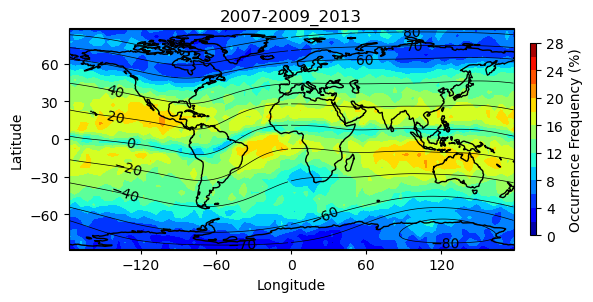

In [19]:
# Plot Occ Freq 
#======================================

averaging_period = '2007-2009_2013'  #or 'Whole_Dataset'

vmin = 0
vmax = 28
nolevs = 15

output_ds_file = f'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_{averaging_period}.nc'
if fivedegbins == 1:
    output_ds_file = f'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_{averaging_period}_5d.nc'
    
output_ds = xr.open_dataset(output_ds_file)
latout = output_ds['latitude']
lonout = output_ds['longitude']
ocfr_out = output_ds['ocfr_lon']



fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lonout, latout, ocfr_out, cmap='jet', levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                     )

ax.coastlines()

ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks([-60,-30,0,30,60])
ax.set_ylabel('Latitude')

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.03, aspect=30, shrink=0.5)
cbar.set_label('Occurrence Frequency (%)')

plt.title(f'{averaging_period}')


#============================================================================
ax2_cosmic = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())

ax2_cosmic.set_global()
contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]
contour = ax2_cosmic.contour(ALon, ALat, ALATM[0, :, :],
                      transform=ccrs.PlateCarree(),
                      colors='black',
                      levels=contour_levels, vmin=-90, vmax=90,
                      linestyles='solid',
                      linewidths=0.5
                      )

ax2_cosmic.patch.set_facecolor('none')
clabels = ax2_cosmic.clabel(contour, inline=True, fontsize=10)
#============================================================================


figname = f'OcFr_latlon_{averaging_period}.png'
if fivedegbins == 1:
    figname = f'OcFr_latlon_{averaging_period}_5d.png'

plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

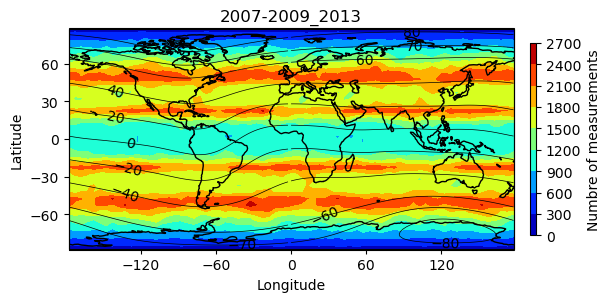

In [20]:
# Plot Nmeas 
#======================================

averaging_period = '2007-2009_2013'  #or 'Whole_Dataset'

# vmin = 0
# vmax = 28
# nolevs = 15

output_ds_file = f'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_{averaging_period}.nc'
if fivedegbins == 1:
    output_ds_file = f'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_{averaging_period}_5d.nc'
    
output_ds = xr.open_dataset(output_ds_file)
latout = output_ds['latitude']
lonout = output_ds['longitude']
nmeas_out = output_ds['nmeas_lon']



fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lonout, latout, nmeas_out, cmap='jet'
                      #, levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                     )

ax.coastlines()

ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks([-60,-30,0,30,60])
ax.set_ylabel('Latitude')

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.03, aspect=30, shrink=0.5)
cbar.set_label('Numbre of measurements')

plt.title(f'{averaging_period}')


#============================================================================
ax2_cosmic = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())

ax2_cosmic.set_global()
contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]
contour = ax2_cosmic.contour(ALon, ALat, ALATM[0, :, :],
                      transform=ccrs.PlateCarree(),
                      colors='black',
                      levels=contour_levels, vmin=-90, vmax=90,
                      linestyles='solid',
                      linewidths=0.5
                      )

ax2_cosmic.patch.set_facecolor('none')
clabels = ax2_cosmic.clabel(contour, inline=True, fontsize=10)
#============================================================================


figname = f'Nmeas_latlon_{averaging_period}.png'
if fivedegbins == 1:
    figname = f'Nmeas_latlon_{averaging_period}_5d.png'

plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

# COSMIC Data Processing: Occ Freq (lat-lon), Individual yrs

In [ ]:
# Processing normal Lat Lon coordinates - whole years separately
#======================================

years = [year for year in range(2006, 2020)]

for year in years:
    
    averaging_period = year
    
    freq_lon = np.zeros((lat_num_bins, lon_num_bins))
    nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
    ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))
    nmeas_lonavg = np.zeros((lat_num_bins))

    ds_length = np.arange(fdatetimes.shape[0])

    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        current_lon = flon.values[i]
        current_s4max = fs4s.values[i]
        current_time = fdatetimes[i]

        year_value = current_time.year


        if year_value == year:
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

            nmeas_lon[lat_bin_index, lon_bin_index] += 1.

            if not np.isnan(current_s4max):
                freq_lon[lat_bin_index, lon_bin_index] += 1.

    ocfr_lon = (freq_lon / nmeas_lon) * 100.0
    nmeas_lonavg = np.average(nmeas_lon, axis=1)
                      
    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
            "nmeas_lon": (['latitude', 'longitude'], nmeas_lon),
            "nmeas_lonavg": (['latitude'], nmeas_lonavg),
        },
        coords={
            "latitude": lat_bin_midpoints,
            "longitude": lon_bin_midpoints,
        },
        attrs={
            'averaging_period': year,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/Whole_yrs/"
    output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}_5d.nc"

    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


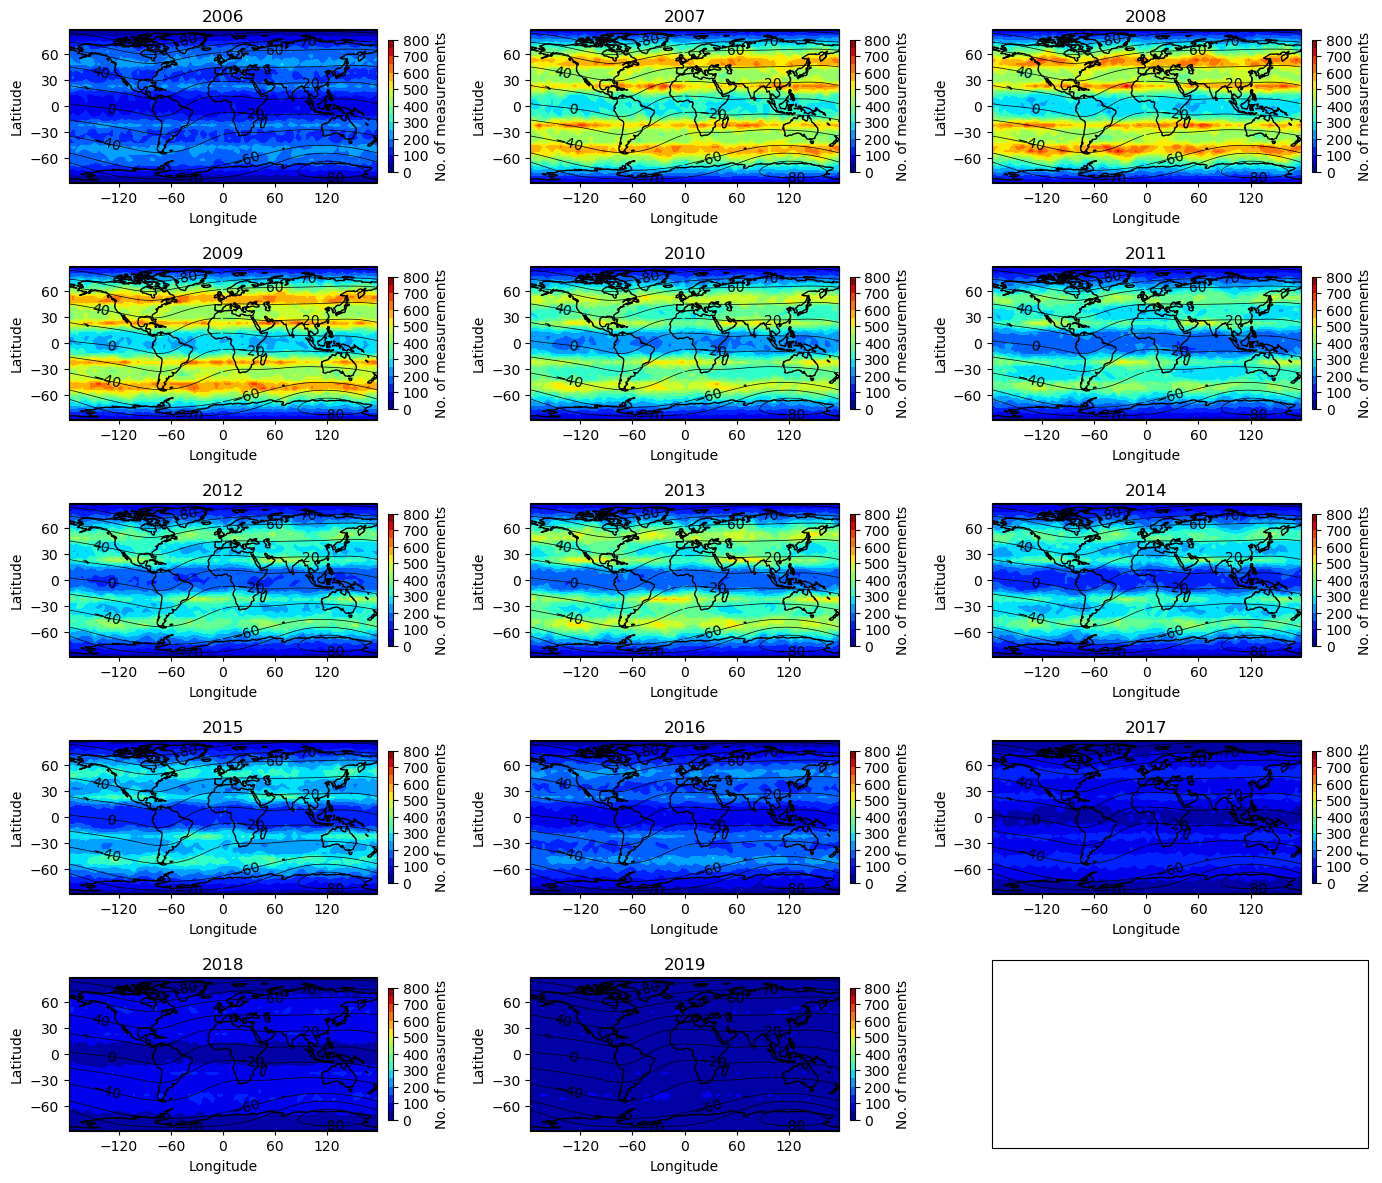

In [22]:
#Plot N meas, yearly

years = [year for year in range(2006, 2020)]

# Define constants
vmin = 0
vmax = 800
nolevs = 17

output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/Whole_yrs/"
fig, axes = plt.subplots(len(years)//3 + 1, 3, figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree()})


for i, year in enumerate(years):
    # Load data for the current year
    output_ds_file = f'{output_directory}Ocfr_Daviddata_{year}.nc'
    if fivedegbins == 1:
        output_ds_file = f'{output_directory}Ocfr_Daviddata_{year}_5d.nc'
    
    output_ds = xr.open_dataset(output_ds_file)
    latout = output_ds['latitude']
    lonout = output_ds['longitude']
    nmeas_out = output_ds['nmeas_lon']

    # Plot the data
    ax = axes[i//3, i%3]
    contour = ax.contourf(lonout, latout, nmeas_out, cmap='jet',
                          levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                         )

    ax.coastlines()
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60,-30,0,30,60])
    ax.set_ylabel('Latitude')

    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.03, aspect=30, shrink=0.7)
    cbar.set_label('No. of measurements')

    ax.set_title(f'{year}')

    # Add magnetic latitude lines
    ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
    ax_mag_lat.set_global()
    contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                         transform=ccrs.PlateCarree(),
                                         colors='black',
                                         levels=contour_levels,
                                         vmin=-90, vmax=90,
                                         linestyles='solid',
                                         linewidths=0.5)
    ax_mag_lat.patch.set_facecolor('none')
    clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)

# Save and show the plot
plt.tight_layout()

figname = f'Nmeas_latlon_yearly.png'
if fivedegbins == 1:
    figname = f'Nmeas_latlon_yearly_5d.png'

plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

# COSMIC Data Processing: Occ Freq (lat-**lon**), Seasons

In [ ]:
# Processing Normal Lat Lon coordinates
# Seasons separately, 2007-2009 and 2013
#======================================

yrs_period = '2007-2009_2013'
years = [2007, 2008, 2009, 2013]

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]

ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = ""
    if set(desired_months) <= {12, 1, 2}:
        season = "winter"
    elif set(desired_months) <= {3, 4, 5}:
        season = "spring"
    elif set(desired_months) <= {6, 7, 8}:
        season = "summer"
    elif set(desired_months) <= {9, 10, 11}:
        season = "autumn"
    else:
        season = "unknown"
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    freq_lon = np.zeros((lat_num_bins, lon_num_bins))
    nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
    ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
    nmeas_lonavg = np.zeros((lat_num_bins))
 
    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        current_lon = flon.values[i]
        current_s4max = fs4s.values[i]
        current_time = fdatetimes[i]
        current_month = current_time.month
    
        year_value = current_time.year
        
        if current_month in desired_months and year_value in years:   
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

            nmeas_lon[lat_bin_index, lon_bin_index] += 1.

            if not np.isnan(current_s4max):
                freq_lon[lat_bin_index, lon_bin_index] += 1.

    ocfr_lon = (freq_lon / nmeas_lon) * 100.0
    nmeas_lonavg = np.average(nmeas_lon, axis=1)

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
            "freq_lon": (['latitude', 'longitude'], freq_lon),
            "nmeas_lon": (['latitude', 'longitude'], nmeas_lon),
            "nmeas_lonavg": (['latitude'], nmeas_lonavg),
        },
        coords={
            "latitude": lat_bin_midpoints,
            "longitude": lon_bin_midpoints,
        },
        attrs={
            'years': yrs_period,
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/seasons/"
    output_file = f"{output_directory}Ocfr_Daviddata_{yrs_period}_{season}.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}Ocfr_Daviddata_{yrs_period}_{season}_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


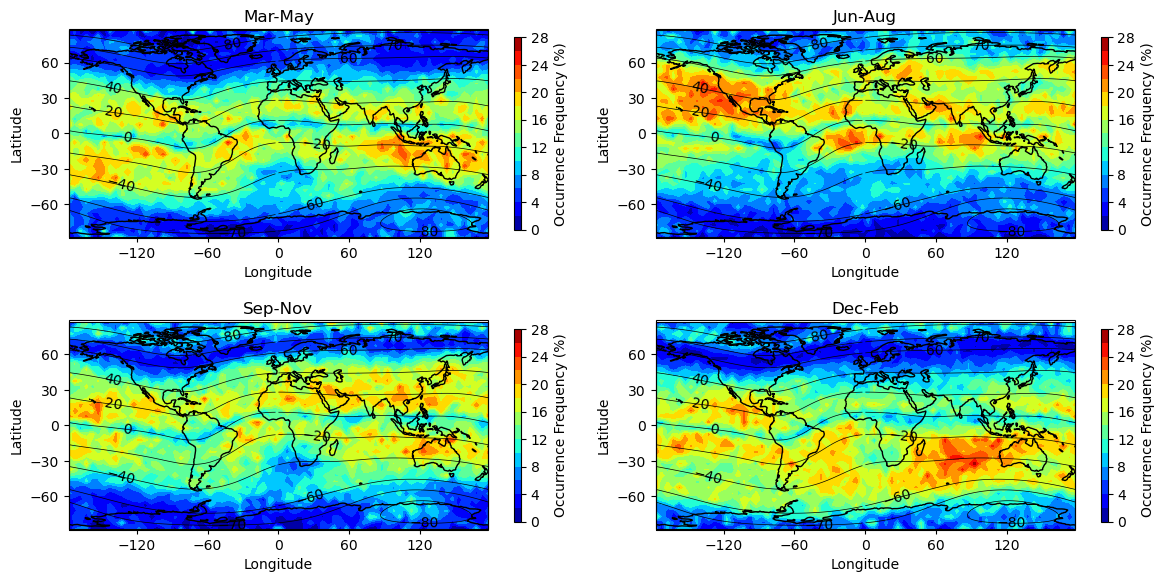

In [23]:
# Plot Occ Freq - seasons separately
#======================================

yrs_period = '2007-2009_2013'
season_periods = ['Mar-May', 'Jun-Aug', 'Sep-Nov', 'Dec-Feb' ]


vmin = 0
vmax = 28
nolevs = 15#(vmax - vmin)+1

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# File paths for each season
file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter.nc',
}

if fivedegbins == 1:
    file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring_5d.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer_5d.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn_5d.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter_5d.nc',
    }


fig, axes = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for i, (season, file_path) in enumerate(file_paths.items()):
    ax = axes.flatten()[i]

    # Load the data for the season
    output_ds = xr.open_dataset(file_path)
    latout = output_ds['latitude']
    lonout = output_ds['longitude']
    ocfr_out = output_ds['ocfr_lon']

    # Plot occurrence frequency
    contour = ax.contourf(lonout, latout, ocfr_out, cmap='jet', transform=ccrs.PlateCarree(), levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                         )
    ax.coastlines()
    ax.set_title(season_periods[i])

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    cbar.set_label('Occurrence Frequency (%)')

    # Add mag lat lines
    ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
    ax_mag_lat.set_global()
    contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                        transform=ccrs.PlateCarree(),
                                        colors='black',
                                        levels=mag_lat_contour_levels,
                                        vmin=-90, vmax=90,
                                        linestyles='solid',
                                        linewidths=0.5
                                        )
    ax_mag_lat.patch.set_facecolor('none')
    clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)

for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'OcFr_latlon_{yrs_period}_seasons.png'
# if fivedegbins == 1:
#     figname = f'OcFr_latlon_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()


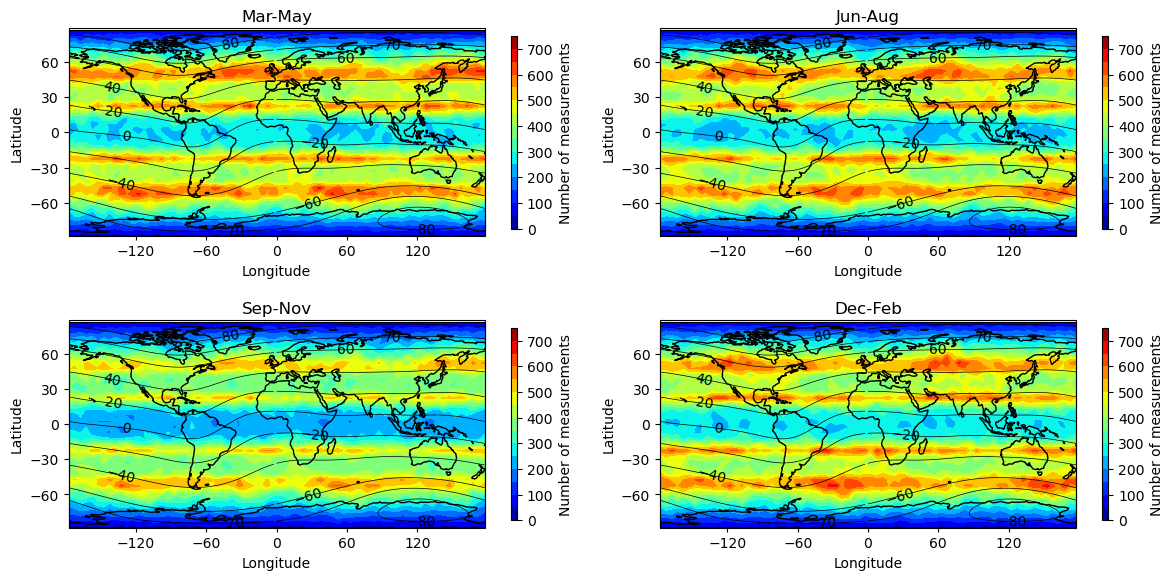

In [24]:
# Plot Nmeas - seasons separately
#======================================

yrs_period = '2007-2009_2013'
season_periods = ['Mar-May', 'Jun-Aug', 'Sep-Nov', 'Dec-Feb' ]


vmin = 0
vmax = 750
nolevs = 16#(vmax - vmin)+1

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# File paths for each season
file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter.nc',
}

if fivedegbins == 1:
    file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring_5d.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer_5d.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn_5d.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter_5d.nc',
}


fig, axes = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for i, (season, file_path) in enumerate(file_paths.items()):
    ax = axes.flatten()[i]

    # Load the data for the season
    output_ds = xr.open_dataset(file_path)
    latout = output_ds['latitude']
    lonout = output_ds['longitude']
    nmeas_out = output_ds['nmeas_lon']

    # Plot occurrence frequency
    contour = ax.contourf(lonout, latout, nmeas_out, cmap='jet', transform=ccrs.PlateCarree()
                          , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                         )
    ax.coastlines()
    ax.set_title(season_periods[i])

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    cbar.set_label('Number of measurements')

    # Add mag lat lines
    ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
    ax_mag_lat.set_global()
    contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                        transform=ccrs.PlateCarree(),
                                        colors='black',
                                        levels=mag_lat_contour_levels,
                                        vmin=-90, vmax=90,
                                        linestyles='solid',
                                        linewidths=0.5
                                        )
    ax_mag_lat.patch.set_facecolor('none')
    clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)

for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'Nmeas_latlon_{yrs_period}_seasons.png'
if fivedegbins == 1:
    figname = f'Nmeas_latlon_{yrs_period}_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()


# COSMIC Data Processing: Occ Freq (lat-**lon**), Seasons - INDIVIDUAL YRS

In [ ]:
fdatetimes

# 2006-04-30 05:56:08.043825024
# ->
# 2019-12-10 12:39:50.466977536

# So:
# Spring years = 2007 - 2019 x13
# Spring years = 2007 - 2019 x14
# Spring years = 2007 - 2019 x14
# Spring years = 2007 - 2019 x13

In [ ]:
# Process data - each year and season

year_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11], [12, 1,2] ]
all_desired_months = []

for d, seasonmonths in enumerate(year_desired_months):

    if set(seasonmonths) <= {3, 4, 5}:
        all_desired_months = [[3, 4, 5]]
        
        # years_set = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        # MAM_date_sets = [
        #     ['2007-03-01', '2007-05-31'], ['2008-03-01', '2008-05-31'], ['2009-03-01', '2009-05-31'],
        #     ['2010-03-01', '2010-05-31'], ['2011-03-01', '2011-05-31'], ['2012-03-01', '2012-05-31'],
        #     ['2013-03-01', '2013-05-31'], ['2014-03-01', '2014-05-31'], ['2015-03-01', '2015-05-31'],
        #     ['2016-03-01', '2016-05-31'], ['2017-03-01', '2017-05-31'], ['2018-03-01', '2018-05-31'],
        #     ['2019-03-01', '2019-05-31']
        # ] 
        
        years_set = ['2007', '2008', '2009', '2013']
        MAM_date_sets = [
            ['2007-03-01', '2007-05-31'], ['2008-03-01', '2008-05-31'], ['2009-03-01', '2009-05-31'],
            ['2013-03-01', '2013-05-31']
        ] 

        
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in MAM_date_sets]

    elif set(seasonmonths) <= {6, 7, 8}:
        
        all_desired_months = [[6, 7, 8]]
        
        # years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        # JJA_date_sets = [
        #     ['2006-06-01', '2006-08-31'], ['2007-06-01', '2007-08-31'], ['2008-06-01', '2008-08-31'],
        #     ['2009-06-01', '2009-08-31'], ['2010-06-01', '2010-08-31'], ['2011-06-01', '2011-08-31'],
        #     ['2012-06-01', '2012-08-31'], ['2013-06-01', '2013-08-31'], ['2014-06-01', '2014-08-31'],
        #     ['2015-06-01', '2015-08-31'], ['2016-06-01', '2016-08-31'], ['2017-06-01', '2017-08-31'],
        #     ['2018-06-01', '2018-08-31'], ['2019-06-01', '2019-08-31']
        # ]
        
        years_set = ['2007', '2008', '2009', '2013']
        JJA_date_sets = [
            ['2007-06-01', '2007-08-31'], ['2008-06-01', '2008-08-31'], ['2009-06-01', '2009-08-31'],  
            ['2013-06-01', '2013-08-31']
        ]
        
        
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in JJA_date_sets]

    elif set(seasonmonths) <= {9, 10, 11}:
        all_desired_months = [[9, 10, 11]]
        
        # years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        # SON_date_sets = [
        #     ['2006-09-01', '2006-11-30'], ['2007-09-01', '2007-11-30'], ['2008-09-01', '2008-11-30'],
        #     ['2009-09-01', '2009-11-30'], ['2010-09-01', '2010-11-30'], ['2011-09-01', '2011-11-30'],
        #     ['2012-09-01', '2012-11-30'], ['2013-09-01', '2013-11-30'], ['2014-09-01', '2014-11-30'],
        #     ['2015-09-01', '2015-11-30'], ['2016-09-01', '2016-11-30'], ['2017-09-01', '2017-11-30'],
        #     ['2018-09-01', '2018-11-30'], ['2019-09-01', '2019-11-30']
        # ]
        
        years_set = ['2007', '2008', '2009', '2013']
        SON_date_sets = [
            ['2007-09-01', '2007-11-30'], ['2008-09-01', '2008-11-30'], ['2009-09-01', '2009-11-30'], 
            ['2013-09-01', '2013-11-30']
        ]

        
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in SON_date_sets]

    elif set(seasonmonths) <= {12, 1, 2}:
        all_desired_months = [[12, 1, 2]]
        
        # years_set = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']
        # DJF_date_sets = [
        #     ['2006-12-01', '2007-02-28'], ['2007-12-01', '2008-02-29'], ['2008-12-01', '2009-02-28'],
        #     ['2009-12-01', '2010-02-28'], ['2010-12-01', '2011-02-28'], ['2011-12-01', '2012-02-29'],
        #     ['2012-12-01', '2013-02-28'], ['2013-12-01', '2014-02-28'], ['2014-12-01', '2015-02-28'],
        #     ['2015-12-01', '2016-02-29'], ['2016-12-01', '2017-02-28'], ['2017-12-01', '2018-02-28'],
        #     ['2018-12-01', '2019-02-28']
        # ]
        
        years_set = ['2007-8', '2008-9', '2009-10', '2013-14']
        DJF_date_sets = [
            ['2007-12-01', '2008-02-29'], ['2008-12-01', '2009-02-28'], ['2009-12-01', '2010-02-28'], 
            ['2013-12-01', '2014-02-28']
        ]
        
            
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in DJF_date_sets]
    else:
        print('error error error')

    # Find the index of the first value for the first date and the last index for the second date in each set
    indices_for_target_dates_sets = [
        [np.where(fdatetimes >= set_dates[0])[0].min(), np.where(fdatetimes <= set_dates[1])[0].max()] for set_dates in target_date_sets
    ]

    # Display the indices for each set of target dates
    for i, indices_for_target_dates in enumerate(indices_for_target_dates_sets):
        print(f'{years_set[i]} {all_desired_months}:')
        print(f"Indices for Target Dates Set {i + 1}: {indices_for_target_dates}")

        #dssl_alt = fhmEs[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lat = flat[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lon = flon[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_s4max = fs4s[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_time = fdatetimes[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        
        year = years_set[i]

        for desired_months in all_desired_months:

            season = ""
            if set(desired_months) <= {12, 1, 2}:
                season = "winter"
            elif set(desired_months) <= {3, 4, 5}:
                season = "spring"
            elif set(desired_months) <= {6, 7, 8}:
                season = "summer"
            elif set(desired_months) <= {9, 10, 11}:
                season = "autumn"
            else:
                season = "unknown"
            
            print({season})
            
            averaging_period = "Three-Month"

            freq_lon = np.zeros((lat_num_bins, lon_num_bins))
            nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
            ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
     
            ###########################################################################################################################
            for i, value in tqdm(dssl_lat.items(), total=len(dssl_lat)):

                current_lat = dssl_lat[i]
                current_lon = dssl_lon[i]
                current_s4max = dssl_s4max[i]
                current_time = dssl_time[i]
                current_month = current_time.month
                #current_hmEs = dssl_alt[i]
    
                if current_month in desired_months:      
                    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
                    lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

                    nmeas_lon[lat_bin_index, lon_bin_index] += 1.

                    if not np.isnan(current_s4max):
                        freq_lon[lat_bin_index, lon_bin_index] += 1.

            ocfr_lon = (freq_lon / nmeas_lon) * 100.0    
              
            
            
            ###########################################################################################################################
            # Save occurrence frequency to nc file
            Ocfr_ds = xr.Dataset(
                data_vars={
                    "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
                    "nmeas_lon": (['latitude', 'longitude'], nmeas_lon),  #this had an error before and dims in output vars are labelled wrong (as local_time). Therefore output files have dims labelled wrong
                    "freq_lon": (['latitude', 'longitude'], freq_lon),    #same as above line
                },
                coords={
                    "latitude": lat_bin_midpoints,
                    "longitude": lon_bin_midpoints,
                },
                attrs={
                    'year': year,
                    'averaging_period': averaging_period,
                    'season': season
               }
            )

            output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"
            
            output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}.nc"
            if fivedegbins == 1:
                output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_5d.nc"
            Ocfr_ds.to_netcdf(output_file)

            ###########################################################################################################################


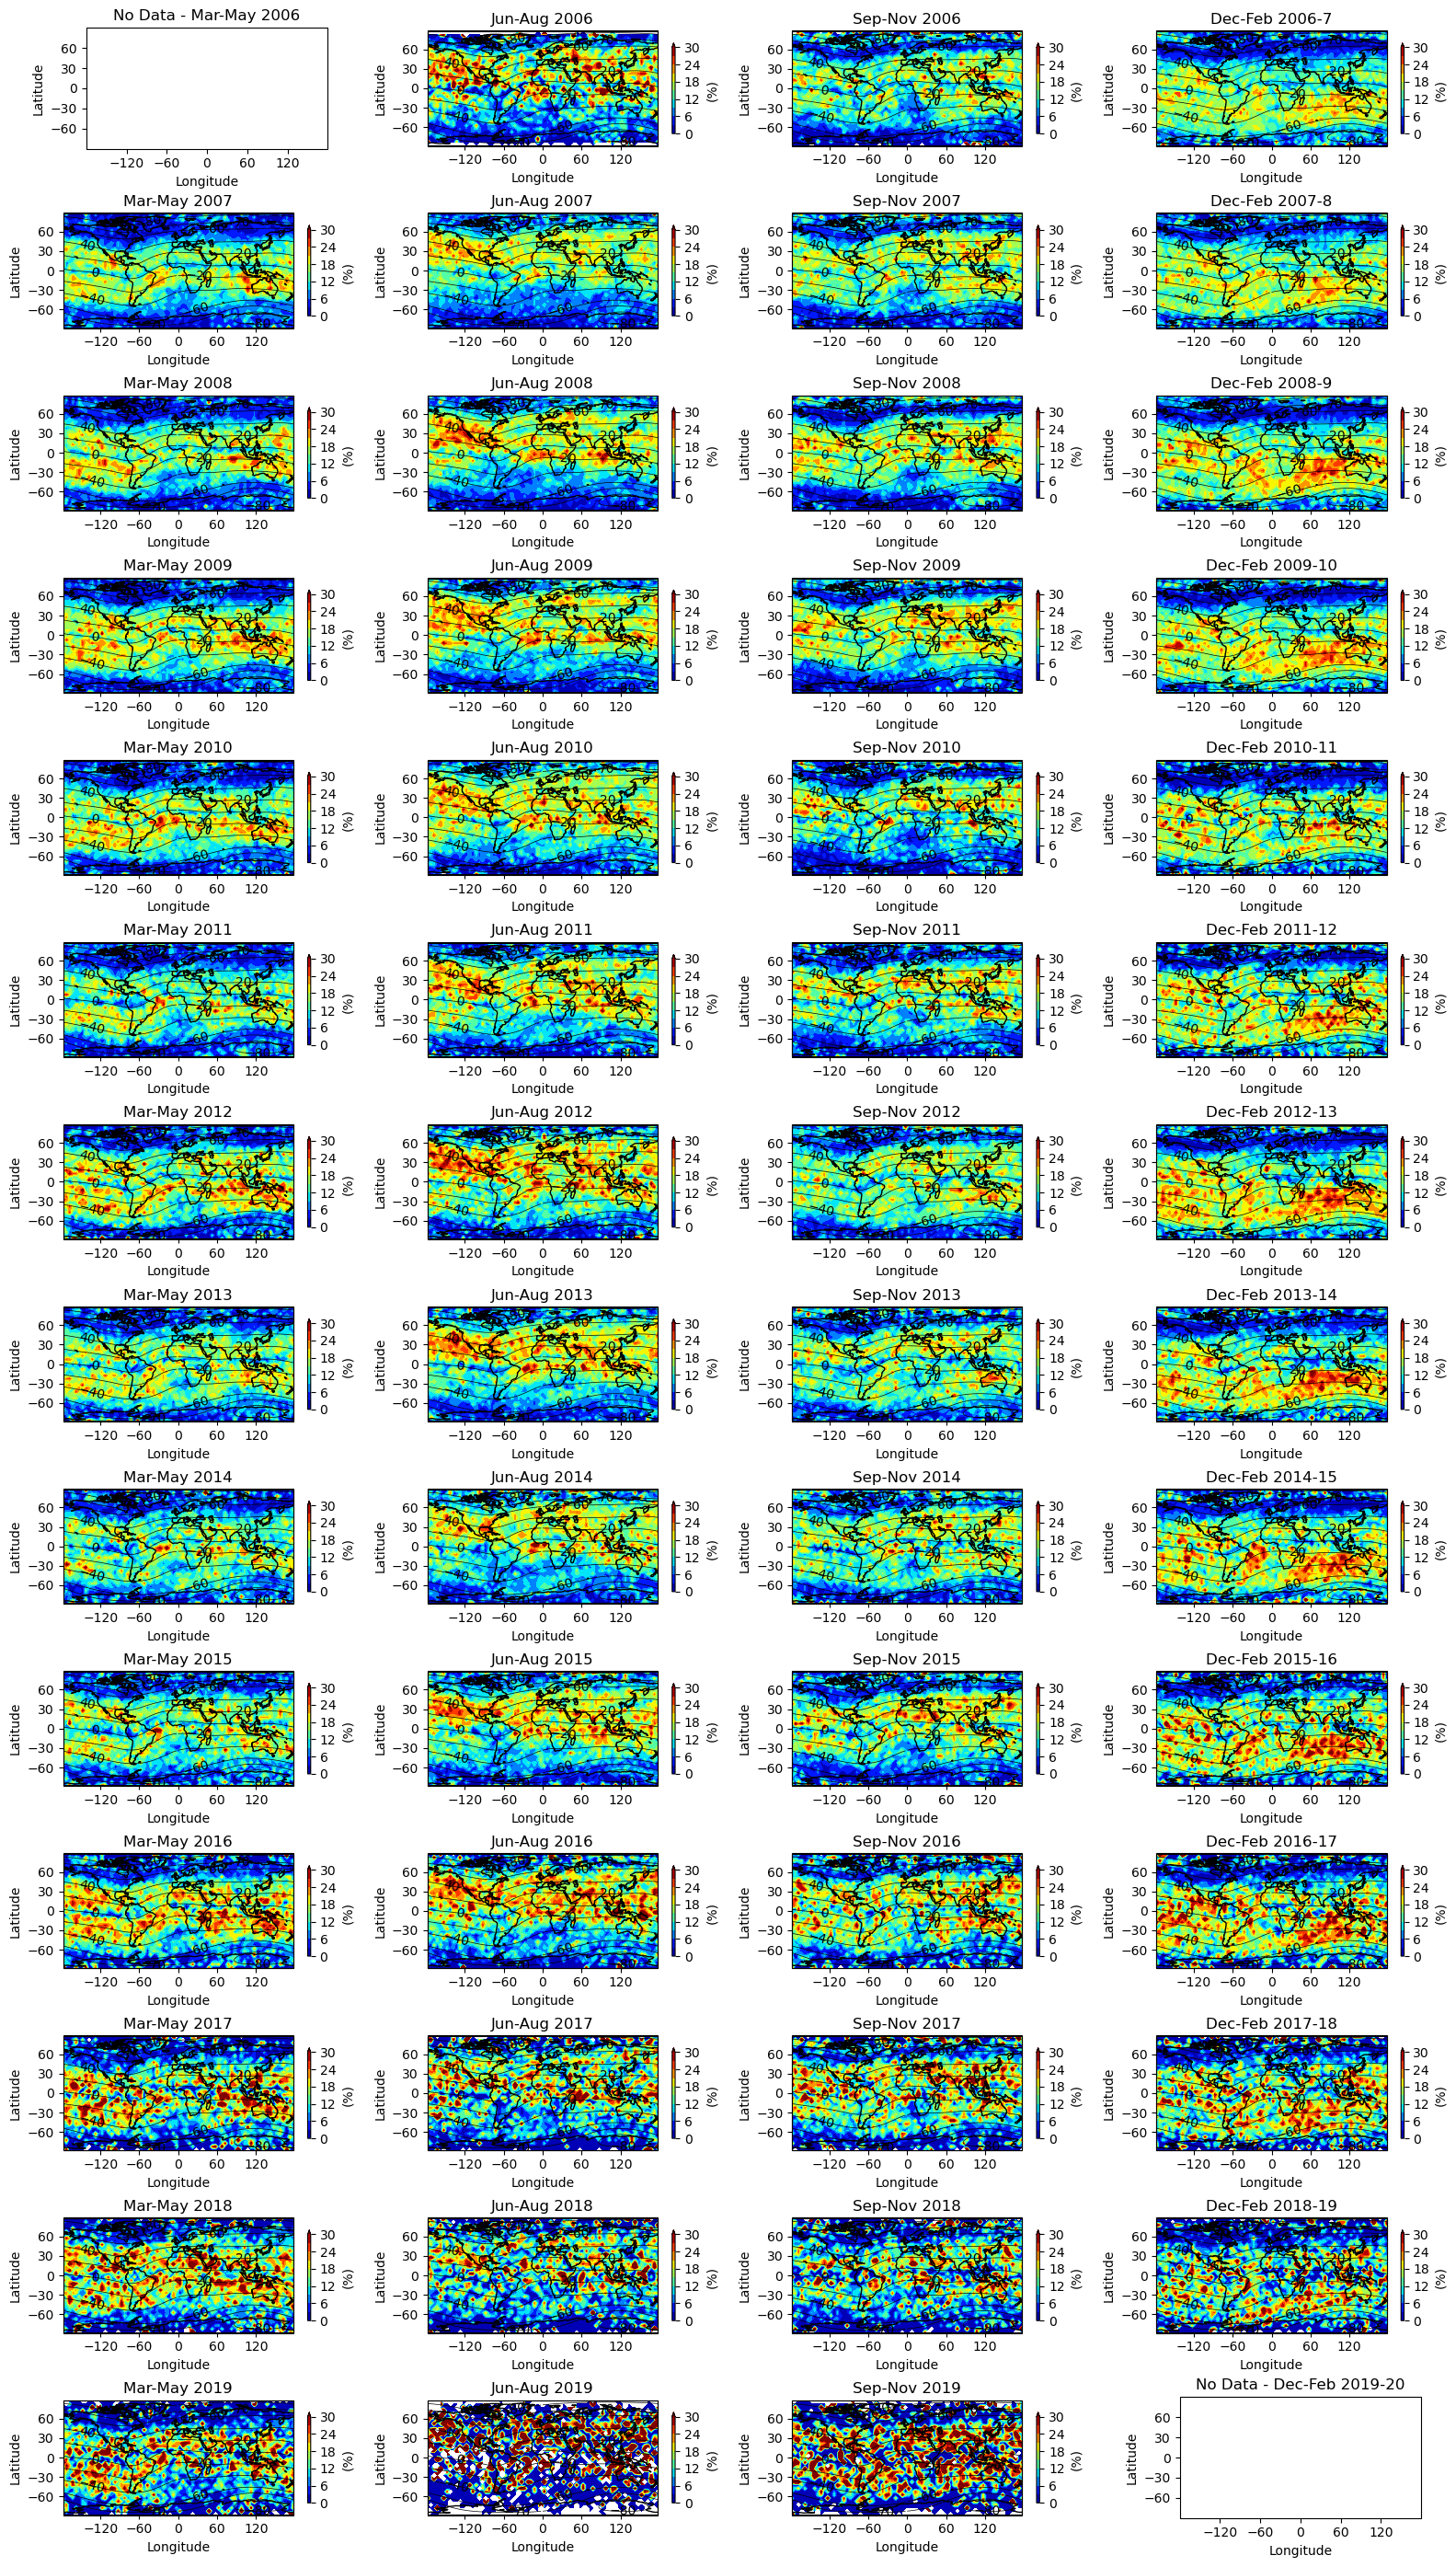

In [25]:
## PLOT ocfr_lon ##
# ALL SEASONS/YEARS #

season_periods = ['Mar-May', 'Jun-Aug', 'Sep-Nov', 'Dec-Feb' ]


cmap = plt.cm.jet
# new_cmap = cmap(np.linspace(0, 1, 256))
# new_cmap[0] = (0.5, 0.5, 0.5, 0.6)  # Set color for zero values to grey with transparency

vmin = 0
vmax = 30
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/lon/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28), subplot_kw={'projection': ccrs.PlateCarree()})

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}.nc'
        else:
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            lonout = output_ds['longitude']
            ocfr_out = output_ds['ocfr_lon']
            # nmeas_lon_out = output_ds['nmeas_lon']
            # freq_lon_out = output_ds['freq_lon']

            # lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            # latout_slice = latout[lat_indices]
            # ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency            
            contour = ax.contourf(lonout, latout, ocfr_out, transform=ccrs.PlateCarree()
                                , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                , extend='max', cmap='jet' #colors.ListedColormap(new_cmap)
                                 )
            
            
            ax.coastlines()
            ax.set_title(f'{season_periods[j]} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('(%)')

            # Add mag lat lines
            ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
            ax_mag_lat.set_global()
            contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                                  transform=ccrs.PlateCarree(),
                                                  colors='black',
                                                  levels=mag_lat_contour_levels,
                                                  vmin=-90, vmax=90,
                                                  linestyles='solid',
                                                  linewidths=0.5
                                                  )
            ax_mag_lat.patch.set_facecolor('none')
            clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)
        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season_periods[j]} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'OcFr_latlon_years_seasons.png'
if fivedegbins == 1:
    figname = f'OcFr_latlon_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


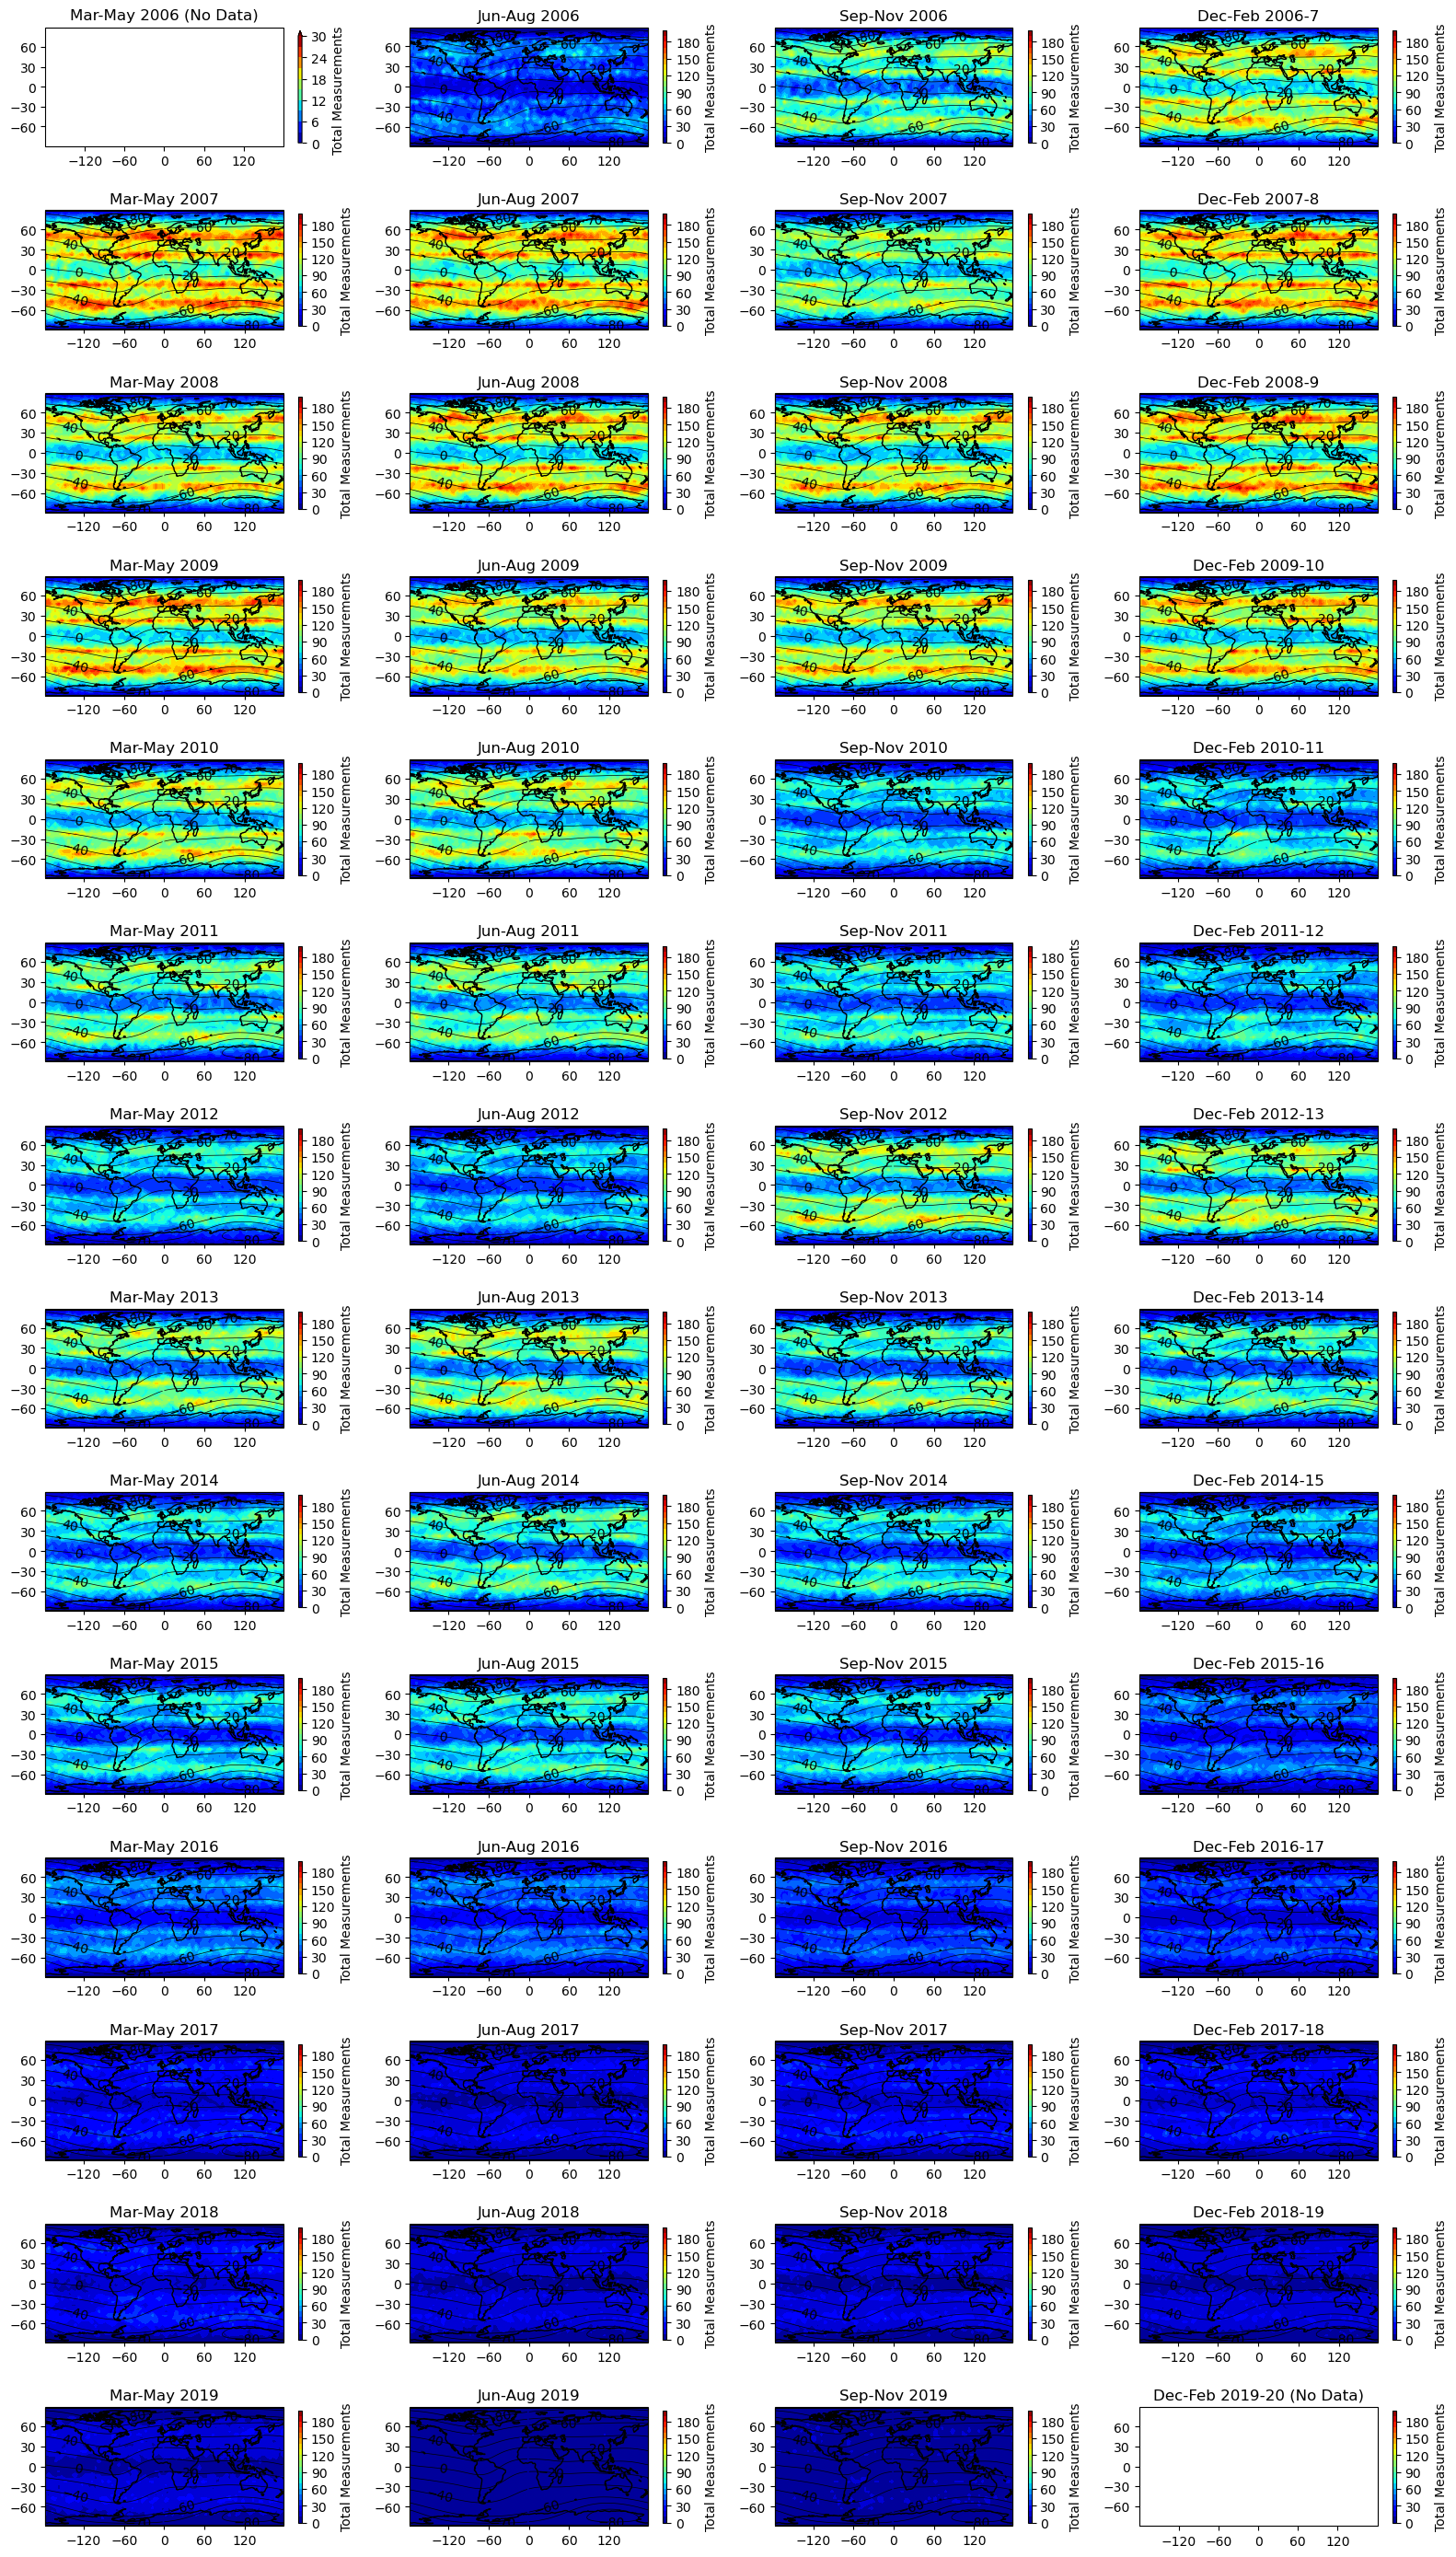

In [26]:
## PLOT nmeas_lon and freq_lon ##
# ALL SEASONS/YEARS #


season_periods = ['Mar-May', 'Jun-Aug', 'Sep-Nov', 'Dec-Feb' ]

cmap = plt.cm.jet
new_cmap = cmap(np.linspace(0, 1, 256))
new_cmap[0] = (0.5, 0.5, 0.5, 0.6)  # Set color for zero values to grey with transparency


# Define constants
vmin = 0
vmax = 200
nolevs = 21

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/lon/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28), subplot_kw={'projection': ccrs.PlateCarree()})

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}.nc'
        else:
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}.nc'
                
        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            lonout = output_ds['longitude']
            ocfr_out = output_ds['ocfr_lon']
            nmeas_lon_out = output_ds['nmeas_lon']
            freq_lon_out = output_ds['freq_lon']

            # lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            # latout_slice = latout[lat_indices]
            # ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(lonout, latout, nmeas_lon_out, cmap=colors.ListedColormap(new_cmap), transform=ccrs.PlateCarree()
                                , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 #,extend='min'
                                 )
            ax.coastlines()
            ax.set_title(f'{season_periods[j]} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            #cbar.set_label('# SpEs')
            cbar.set_label('Total Measurements')

            # Add mag lat lines
            ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
            ax_mag_lat.set_global()
            contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                                  transform=ccrs.PlateCarree(),
                                                  colors='black',
                                                  levels=mag_lat_contour_levels,
                                                  vmin=-90, vmax=90,
                                                  linestyles='solid',
                                                  linewidths=0.5
                                                  )
            ax_mag_lat.patch.set_facecolor('none')
            clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)
        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'{season_periods[j]} {year} (No Data)')
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('Total Measurements')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    #ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    #ax.set_ylabel('Latitude')

plt.tight_layout()


if fivedegbins == 1:
    figname = f'n_meas_latlon_years_seasons_5d.png'
    #figname = f'n_SpEs_latlon_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


# COSMIC Data Processing: Inter-Year Standard Deviations (lat-**lon**) for each season

In [1]:
# OLD - NOT USING

# # Standard Deviation over time (multiple years)
# # Different years for winter / all other seasons 

# # Define seasons, years, and output directory
# seasons = ['spring', 'summer', 'autumn', 'winter']

# # Davids data goes from summer 06 to autumn 19 inclusive. 
# # Chinese groups data went from spring 07 to aut 2013

# yr_1 = 2007
# yr_2 = 2014 # inclusive
# yr_1_str = str(yr_1)[-2:]
# yr_2_str = str(yr_2)[-2:]

# yr_1_win = 2007 # start year of two e.g. 06-07
# yr_2_win = 2014 # index one higher than needed
# yr_1_win_str = str(yr_1_win)[-2:]
# yr_2_win_str = str(yr_2_win)[-2:]


# years = list(range(yr_1, yr_2+1))  # For spring, summer, and autumn
# years_winter = list(range(yr_1_win, yr_2_win+1))  # For winter
# file_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"

# # Initialize an empty dataset to store standard deviations
# std_dev_dataset = xr.Dataset()

# # Loop through seasons
# for season in seasons:
#     # Define a list to store datasets for each year
#     datasets = []

#     # Loop through years
#     if season == 'winter':
#         years_to_loop = years_winter
#     else:
#         years_to_loop = years

#     for year in years_to_loop:
#         # Define the file pattern
#         if season == 'winter':
#             yr_last_two_digits = str(int(str(year)[-2:]) + 1)
#             file_pattern = f"{file_directory}Ocfr_Daviddata_{year}-{yr_last_two_digits}_{season}_5d.nc"
#         else:
#             file_pattern = f"{file_directory}Ocfr_Daviddata_{year}_{season}_5d.nc"

#         # Open the dataset
#         ocfr_ds = xr.open_dataset(file_pattern)

#         # Add a 'time' coordinate representing the year
#         ocfr_ds['time'] = xr.DataArray([year], dims='time', coords={'time': [year]})

#         # Append the dataset to the list
#         datasets.append(ocfr_ds)

#     # Concatenate along the time dimension
#     combined_ds = xr.concat(datasets, dim='time')

#     # Calculate the standard deviation for ocfr_lon
#     std_dev_lon = combined_ds['ocfr_lon'].std(dim='time')
#     #std_dev_LT = combined_ds['ocfr_LT'].std(dim='time')

#     # Add the standard deviations to the result dataset
#     std_dev_dataset[f'std_dev_ocfr_lon_{season}'] = std_dev_lon
#     #std_dev_dataset[f'std_dev_ocfr_LT_{season}'] = std_dev_LT


#     output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"
#     if season == 'winter':
#         output_file = f"{output_directory}Ocfr_stddev_{season}_5d_{yr_1_win_str}-{yr_2_win_str}.nc"
#     else:
#         output_file = f"{output_directory}Ocfr_stddev_{season}_5d_{yr_1_str}-{yr_2_str}.nc"

#     try:
#         std_dev_dataset.to_netcdf(output_file)
#         print(f"File saved successfully: {output_file}")
#     except Exception as e:
#         print(f"Error saving the file: {e}")
#     finally:
#         std_dev_dataset.close()

In [ ]:
# OLD - NOT USING

# # Standard Deviation over time (multiple years)
# # Different years for EACH SEASON
# # Currently not for 5x5' bins

# # Define seasons, years, and output directory
# seasons = ['spring', 'summer', 'autumn', 'winter']

# # Davids data goes from summer 06 to autumn 19 inclusive. 
# # Chinese groups data went from spring 07 to aut 2013

# # All years
# yr_1_spr = 2007
# yr_2_spr = 2019 # inclusive
# yr_1_sum = 2006
# yr_2_sum = 2019 # inclusive
# yr_1_aut = 2006
# yr_2_aut = 2019 # inclusive
# yr_1_win = 2006 # start year of two e.g. 06-07
# yr_2_win = 2018 # inclusive
 
# # yr_1_spr = 2007
# # yr_2_spr = 2014 # inclusive
# # yr_1_sum = 2007
# # yr_2_sum = 2014 # inclusive
# # yr_1_aut = 2007
# # yr_2_aut = 2014 # inclusive
# # yr_1_win = 2007 # start year of two e.g. 06-07
# # yr_2_win = 2014 # inclusive


# years_spr = list(range(yr_1_spr, yr_2_spr+1))  
# years_sum = list(range(yr_1_sum, yr_2_sum+1)) 
# years_aut = list(range(yr_1_aut, yr_2_aut+1)) 
# years_winter = list(range(yr_1_win, yr_2_win+1))  # For winter

# file_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"

# # Initialize an empty dataset to store standard deviations
# std_dev_dataset = xr.Dataset()

# # Loop through seasons
# for season in seasons:
#     # Initialize an empty dataset to store standard deviations
#     std_dev_dataset = xr.Dataset()
    
#     # Define a list to store datasets for each year
#     datasets = []

#     # Loop through years
#     if season == 'winter':
#         years_to_loop = years_winter
#     elif season == 'spring':
#         years_to_loop = years_spr
#     elif season == 'summer':
#         years_to_loop = years_sum
#     elif season == 'autumn':
#         years_to_loop = years_aut

#     for year in years_to_loop:
#         # Define the file pattern
#         if season == 'winter':
#             yr_last_two_digits = str(int(str(year)[-2:]) + 1)
#             file_pattern = f"{file_directory}Ocfr_Daviddata_{year}-{yr_last_two_digits}_{season}.nc"
#         else:
#             file_pattern = f"{file_directory}Ocfr_Daviddata_{year}_{season}.nc"

#         # Open the dataset
#         ocfr_ds = xr.open_dataset(file_pattern)

#         # Add a 'time' coordinate representing the year
#         ocfr_ds['time'] = xr.DataArray([year], dims='time', coords={'time': [year]})

#         # Append the dataset to the list
#         datasets.append(ocfr_ds)

#     # Concatenate along the time dimension
#     combined_ds = xr.concat(datasets, dim='time')

#     # Calculate the standard deviation for ocfr_lon
#     std_dev_lon = combined_ds['ocfr_lon'].std(dim='time')
#     #std_dev_LT = combined_ds['ocfr_LT'].std(dim='time')

#     # Add the standard deviations to the result dataset
#     std_dev_dataset[f'std_dev_ocfr_lon_{season}'] = std_dev_lon
#     #std_dev_dataset[f'std_dev_ocfr_LT_{season}'] = std_dev_LT


#     output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"
#     if season == 'winter':
#         output_file = f"{output_directory}Ocfr_stddev_{season}_{str(yr_1_win)[-2:]}-{str(yr_2_win)[-2:]}.nc"
#     elif season == 'spring':
#         output_file = f"{output_directory}Ocfr_stddev_{season}_{str(yr_1_spr)[-2:]}-{str(yr_2_spr)[-2:]}.nc"
#     elif season == 'summer':
#         output_file = f"{output_directory}Ocfr_stddev_{season}_{str(yr_1_sum)[-2:]}-{str(yr_2_sum)[-2:]}.nc"
#     elif season == 'autumn':
#         output_file = f"{output_directory}Ocfr_stddev_{season}_{str(yr_1_aut)[-2:]}-{str(yr_2_aut)[-2:]}.nc"
        
#     try:
#         std_dev_dataset.to_netcdf(output_file)
#         print(f"File saved successfully: {output_file}")
#     except Exception as e:
#         print(f"Error saving the file: {e}")
#     finally:
#         std_dev_dataset.close()

In [ ]:
# CURRENTLY USING THIS VERSION

# Standard Deviation over time (multiple years)
# Same years for EACH SEASON

# Define seasons, years, and output directory
seasons = ['spring', 'summer', 'autumn', 'winter']

years = [2007, 2008, 2009, 2013] 

file_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"

# Initialize an empty dataset to store standard deviations
std_dev_dataset = xr.Dataset()

# Loop through seasons
for season in seasons:
    # Initialize an empty dataset to store standard deviations
    std_dev_dataset = xr.Dataset()
    
    # Define a list to store datasets for each year
    datasets = []


    for year in years:
        # Define the file pattern
        if season == 'winter':
            yr_last_two_digits = str(int(str(year)[-2:]) + 1)
            if fivedegbins ==1:
                file_pattern = f"{file_directory}Ocfr_Daviddata_{year}-{yr_last_two_digits}_{season}_5d.nc"
            else:
                file_pattern = f"{file_directory}Ocfr_Daviddata_{year}-{yr_last_two_digits}_{season}.nc"
        else:
            if fivedegbins ==1:
                file_pattern = f"{file_directory}Ocfr_Daviddata_{year}_{season}_5d.nc"
            else:
                file_pattern = f"{file_directory}Ocfr_Daviddata_{year}_{season}.nc"

        # Open the dataset
        ocfr_ds = xr.open_dataset(file_pattern)

        # Add a 'time' coordinate representing the year
        ocfr_ds['time'] = xr.DataArray([year], dims='time', coords={'time': [year]})

        # Append the dataset to the list
        datasets.append(ocfr_ds)
    
    # Concatenate along the time dimension
    combined_ds = xr.concat(datasets, dim='time')

    # Calculate the standard deviation for ocfr_lon
    std_dev_lon = combined_ds['ocfr_lon'].std(dim='time')
    #std_dev_LT = combined_ds['ocfr_LT'].std(dim='time')

    # Add the standard deviations to the result dataset
    std_dev_dataset[f'std_dev_ocfr_lon_{season}'] = std_dev_lon
    #std_dev_dataset[f'std_dev_ocfr_LT_{season}'] = std_dev_LT


    output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"

    if fivedegbins ==1:
        output_file = f"{output_directory}Ocfr_stddev_{season}_{str(years[0])[-2:]}-{str(years[1])[-2:]}-{str(years[2])[-2:]}-{str(years[3])[-2:]}_5d.nc"
    else:
        output_file = f"{output_directory}Ocfr_stddev_{season}_{str(years[0])[-2:]}-{str(years[1])[-2:]}-{str(years[2])[-2:]}-{str(years[3])[-2:]}.nc"
    
    try:
        std_dev_dataset.to_netcdf(output_file)
        print(f"File saved successfully: {output_file}")
    except Exception as e:
        print(f"Error saving the file: {e}")
    finally:
        std_dev_dataset.close()

# COSMIC Data Processing: Occ Freq (lat-**LT**), Seasons 

In [ ]:
# Processing  Lat LT coordinates
# Seasons separately
#======================================

yrs_period = '2007-2009_2013'
years = [2007, 2008, 2009, 2013]

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]
month_to_season = {
    (12, 1, 2): "winter",
    (3, 4, 5): "spring",
    (6, 7, 8): "summer",
    (9, 10, 11): "autumn" }
 
ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = month_to_season.get(tuple(desired_months), "unknown")
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    freq_LT = np.zeros((lat_num_bins, LT_num_bins))
    nmeas_LT = np.zeros((lat_num_bins, LT_num_bins))
    ocfr_LT = np.zeros((lat_num_bins, LT_num_bins))   

    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        #current_lon = flon.values[i]
        
        current_LT = local_times[i]
        time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
        
        current_s4max = fs4s.values[i]
        
        current_time = fdatetimes[i]
        current_month = current_time.month
        year_value = current_time.year
        
        if current_month in desired_months and year_value in years:        
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            #lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1
            LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            
            nmeas_LT[lat_bin_index, LT_bin_index] += 1.

            if not np.isnan(current_s4max):
                freq_LT[lat_bin_index, LT_bin_index] += 1.

    ocfr_LT = (freq_LT / nmeas_LT) * 100.0

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "ocfr_LT": (['latitude', 'local_time'], ocfr_LT),
            "nmeas_LT": (['latitude', 'local_time'], nmeas_LT),
        },
        coords={
            "latitude": lat_bin_midpoints,
            "local_time": LT_bin_midpoints,
        },
        attrs={
            'years': yrs_period,
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/seasons/"
    output_file = f"{output_directory}Ocfr_Daviddata_{yrs_period}_{season}_LT.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}Ocfr_Daviddata_{yrs_period}_{season}_LT_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


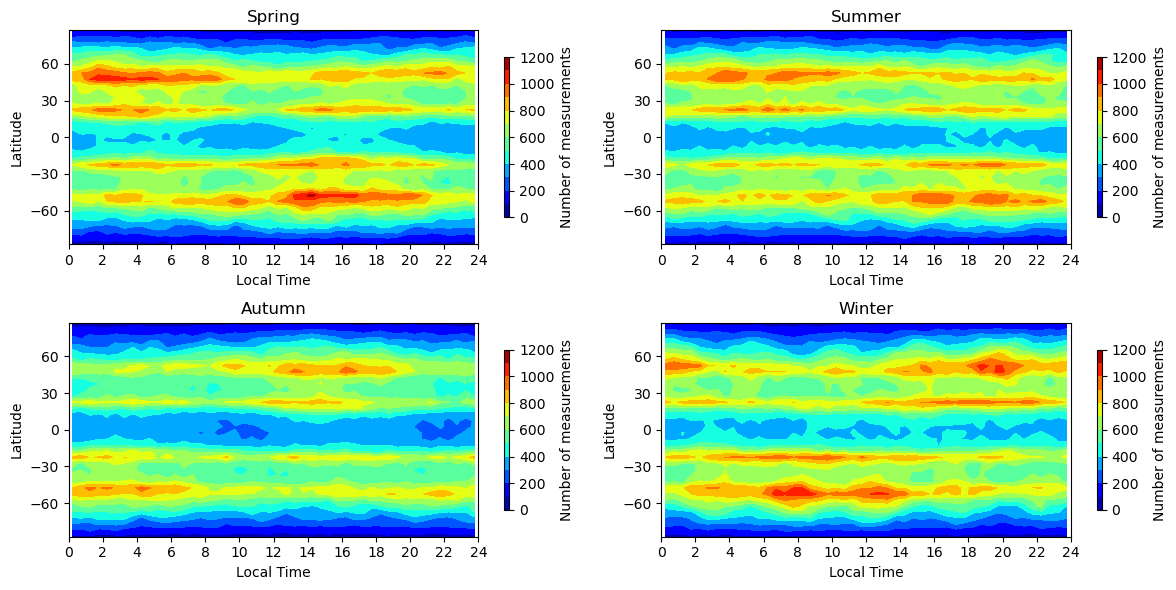

In [27]:
# Plot Nmeas - seasons separately
#======================================


vmin = 0
vmax = 1200
nolevs = 13#(vmax - vmin)+1

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# File paths for each season
file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring_LT.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer_LT.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn_LT.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter_LT.nc',
}

if fivedegbins == 1:
    file_paths = {
    'Spring': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_spring_LT_5d.nc',
    'Summer': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_summer_LT_5d.nc',
    'Autumn': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_autumn_LT_5d.nc',
    'Winter': f'Nc_Files/s4max/Daviddata/seasons/Ocfr_Daviddata_{yrs_period}_winter_LT_5d.nc',
}


fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, (season, file_path) in enumerate(file_paths.items()):
    ax = axes.flatten()[i]

    # Load the data for the season
    output_ds = xr.open_dataset(file_path)
    latout = output_ds['latitude']
    LTout = output_ds['local_time']
    nmeas_out = output_ds['nmeas_LT']

    # Plot occurrence frequency
    contour = ax.contourf(LTout, latout, nmeas_out, cmap='jet'
                          , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                         )

    ax.set_title(season)

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    cbar.set_label('Number of measurements')


for ax in axes.flat:
    xticks = np.linspace(0, 24, 13)
    ax.set_xticks(xticks)
    ax.set_xlabel('Local Time')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'Nmeas_latLT_{yrs_period}_seasons.png'
if fivedegbins == 1:
    figname = f'Nmeas_latLT_{yrs_period}_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()


# COSMIC Data Processing: Occ Freq (lat-**LT**), Seasons - INDIVIDUAL YEARS

In [ ]:
# Process data - each year and season

year_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11], [12, 1,2] ]
all_desired_months = []

for d, seasonmonths in enumerate(year_desired_months):

    if set(seasonmonths) <= {3, 4, 5}:
        all_desired_months = [[3, 4, 5]]
        years_set = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        MAM_date_sets = [
            ['2007-03-01', '2007-05-31'], ['2008-03-01', '2008-05-31'], ['2009-03-01', '2009-05-31'],
            ['2010-03-01', '2010-05-31'], ['2011-03-01', '2011-05-31'], ['2012-03-01', '2012-05-31'],
            ['2013-03-01', '2013-05-31'], ['2014-03-01', '2014-05-31'], ['2015-03-01', '2015-05-31'],
            ['2016-03-01', '2016-05-31'], ['2017-03-01', '2017-05-31'], ['2018-03-01', '2018-05-31'],
            ['2019-03-01', '2019-05-31']
        ] 
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in MAM_date_sets]

    elif set(seasonmonths) <= {6, 7, 8}:
        
        all_desired_months = [[6, 7, 8]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        JJA_date_sets = [
            ['2006-06-01', '2006-08-31'], ['2007-06-01', '2007-08-31'], ['2008-06-01', '2008-08-31'],
            ['2009-06-01', '2009-08-31'], ['2010-06-01', '2010-08-31'], ['2011-06-01', '2011-08-31'],
            ['2012-06-01', '2012-08-31'], ['2013-06-01', '2013-08-31'], ['2014-06-01', '2014-08-31'],
            ['2015-06-01', '2015-08-31'], ['2016-06-01', '2016-08-31'], ['2017-06-01', '2017-08-31'],
            ['2018-06-01', '2018-08-31'], ['2019-06-01', '2019-08-31']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in JJA_date_sets]

    elif set(seasonmonths) <= {9, 10, 11}:
        all_desired_months = [[9, 10, 11]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        SON_date_sets = [
            ['2006-09-01', '2006-11-30'], ['2007-09-01', '2007-11-30'], ['2008-09-01', '2008-11-30'],
            ['2009-09-01', '2009-11-30'], ['2010-09-01', '2010-11-30'], ['2011-09-01', '2011-11-30'],
            ['2012-09-01', '2012-11-30'], ['2013-09-01', '2013-11-30'], ['2014-09-01', '2014-11-30'],
            ['2015-09-01', '2015-11-30'], ['2016-09-01', '2016-11-30'], ['2017-09-01', '2017-11-30'],
            ['2018-09-01', '2018-11-30'], ['2019-09-01', '2019-11-30']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in SON_date_sets]

    elif set(seasonmonths) <= {12, 1, 2}:
        all_desired_months = [[12, 1, 2]]
        years_set = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']
        DJF_date_sets = [
            ['2006-12-01', '2007-02-28'], ['2007-12-01', '2008-02-29'], ['2008-12-01', '2009-02-28'],
            ['2009-12-01', '2010-02-28'], ['2010-12-01', '2011-02-28'], ['2011-12-01', '2012-02-29'],
            ['2012-12-01', '2013-02-28'], ['2013-12-01', '2014-02-28'], ['2014-12-01', '2015-02-28'],
            ['2015-12-01', '2016-02-29'], ['2016-12-01', '2017-02-28'], ['2017-12-01', '2018-02-28'],
            ['2018-12-01', '2019-02-28']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in DJF_date_sets]
    else:
        print('error error error')

    # Find the index of the first value for the first date and the last index for the second date in each set
    indices_for_target_dates_sets = [
        [np.where(fdatetimes >= set_dates[0])[0].min(), np.where(fdatetimes <= set_dates[1])[0].max()] for set_dates in target_date_sets
    ]

    # Display the indices for each set of target dates
    for i, indices_for_target_dates in enumerate(indices_for_target_dates_sets):
        print(f'{years_set[i]} {all_desired_months}:')
        print(f"Indices for Target Dates Set {i + 1}: {indices_for_target_dates}")

        #dssl_alt = fhmEs[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lat = flat[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lon = flon[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_s4max = fs4s[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_time = fdatetimes[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]

        dssl_LT = local_times[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        
        year = years_set[i]

        for desired_months in all_desired_months:

            season = ""
            if set(desired_months) <= {12, 1, 2}:
                season = "winter"
            elif set(desired_months) <= {3, 4, 5}:
                season = "spring"
            elif set(desired_months) <= {6, 7, 8}:
                season = "summer"
            elif set(desired_months) <= {9, 10, 11}:
                season = "autumn"
            else:
                season = "unknown"
            
            print({season})
            
            averaging_period = "Three-Month"

            freq_LT = np.zeros((lat_num_bins, LT_num_bins))
            nmeas_LT = np.zeros((lat_num_bins, LT_num_bins))
            ocfr_LT = np.zeros((lat_num_bins, LT_num_bins))  

            ###########################################################################################################################

            for idx, (i, _) in tqdm(enumerate(dssl_lat.items()), total=len(dssl_lat)):
                # print(f'i= {i}')
                # print(f'idx= {idx}')
                
                current_lat = dssl_lat[i]
                #current_lon = dssl_lon[i]
                current_s4max = dssl_s4max[i]
                
                current_time = dssl_time[i]
                current_month = current_time.month
    
                current_LT = dssl_LT[idx]
                time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
    
                if current_month in desired_months:      
                    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
                    LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            
                    nmeas_LT[lat_bin_index, LT_bin_index] += 1.

                    if not np.isnan(current_s4max):
                        freq_LT[lat_bin_index, LT_bin_index] += 1.

            ocfr_LT = (freq_LT / nmeas_LT) * 100.0

            ###########################################################################################################################
            # Save occurrence frequency to nc file
            Ocfr_ds = xr.Dataset(
                data_vars={
                    "ocfr_LT": (['latitude', 'local_time'], ocfr_LT),
                    "nmeas_LT": (['latitude', 'local_time'], nmeas_LT),
                    "freq_LT": (['latitude', 'local_time'], freq_LT),
                },
                coords={
                    "latitude": lat_bin_midpoints,
                    "local_time": LT_bin_midpoints,
                },
                attrs={
                    'year': year,
                    'averaging_period': averaging_period,
                    'season': season
               }
            )

            output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/LT/"
            
            output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_LT.nc"
            if fivedegbins == 1:
                output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc"
            Ocfr_ds.to_netcdf(output_file)

            ###########################################################################################################################


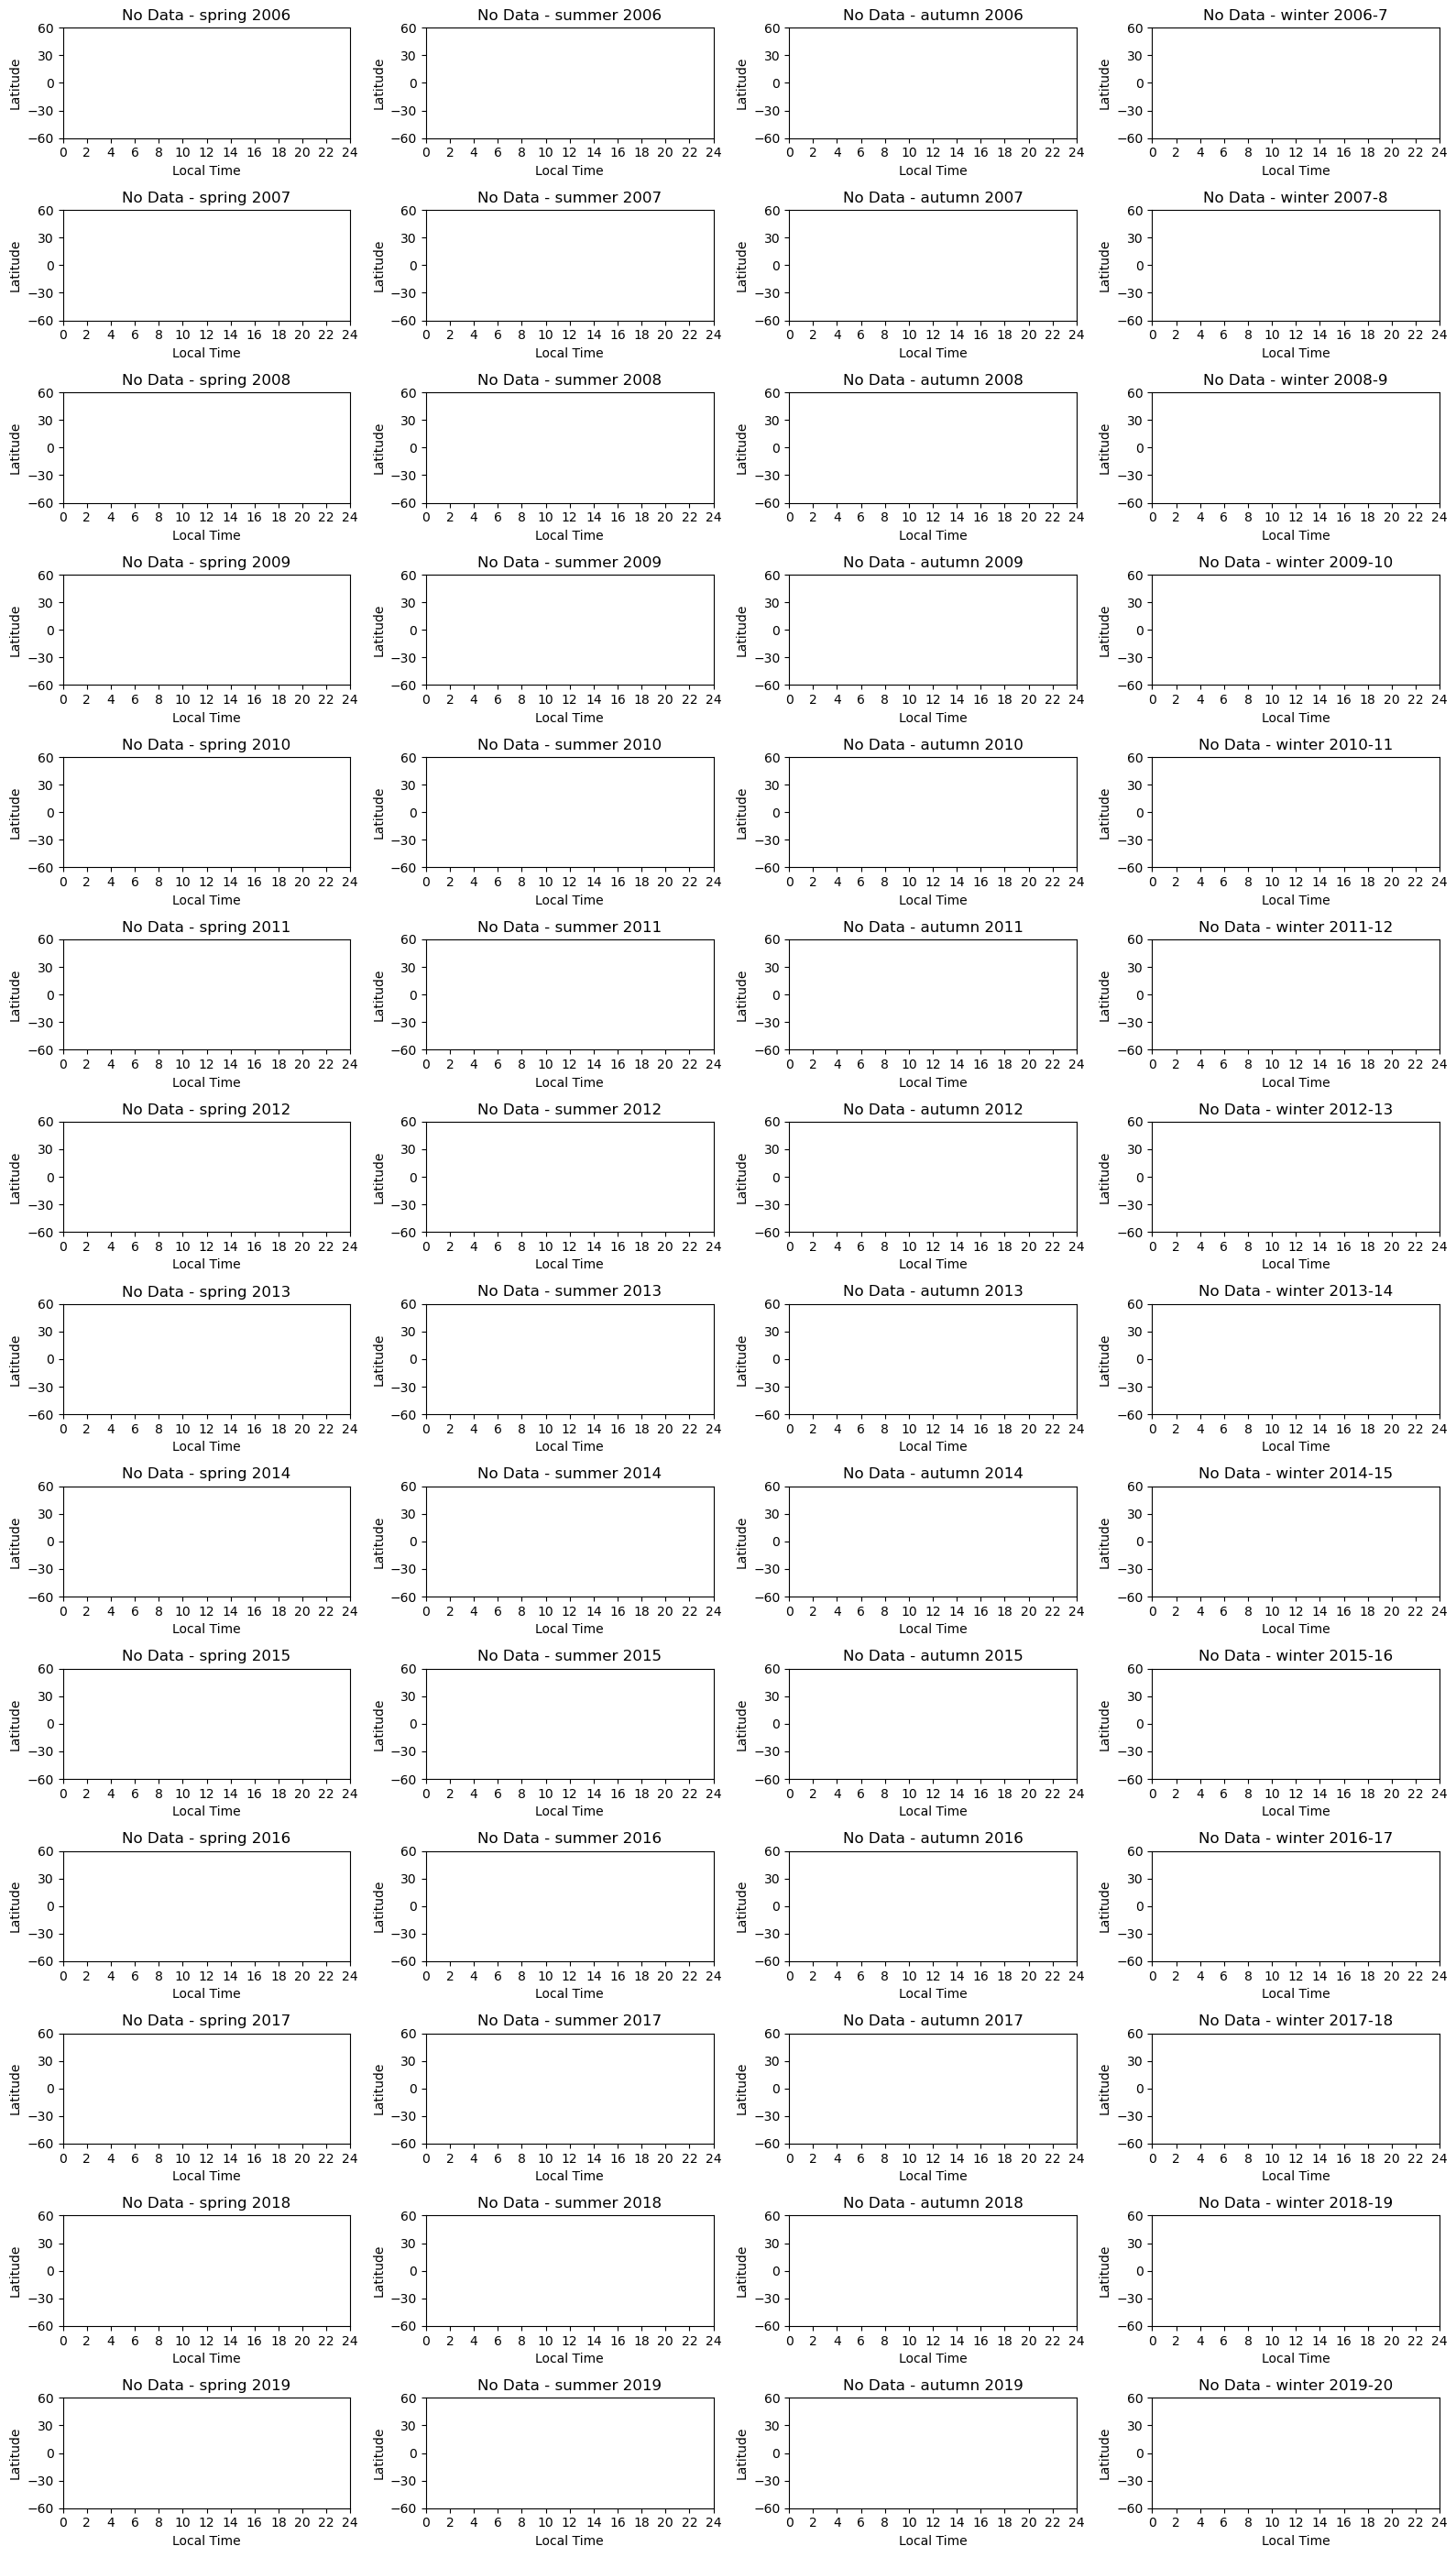

In [28]:
## PLOT ocfr_LT ##
# NOTE, will not work for fivedegbins=1 as there is only data for fivedegbins=0


# Define constants
vmin = 0
vmax = 30
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/LT/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28))

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT.nc'
        else:
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            ltout = output_ds['local_time']
            ocfr_out = output_ds['ocfr_LT']

            lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            latout_slice = latout[lat_indices]
            ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(ltout, latout, ocfr_out, cmap='jet'
                                  , extend = 'max'
                                , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 )
            
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('(%)')

        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    xticks = np.linspace(0, 24, 13)
    ax.set_xticks(xticks)
    ax.set_xlabel('Local Time')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()


if fivedegbins == 1:
    figname = f'OcFr_latLT_years_seasons_5d.png'
else:
    figname = f'OcFr_latLT_years_seasons.png'    

plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


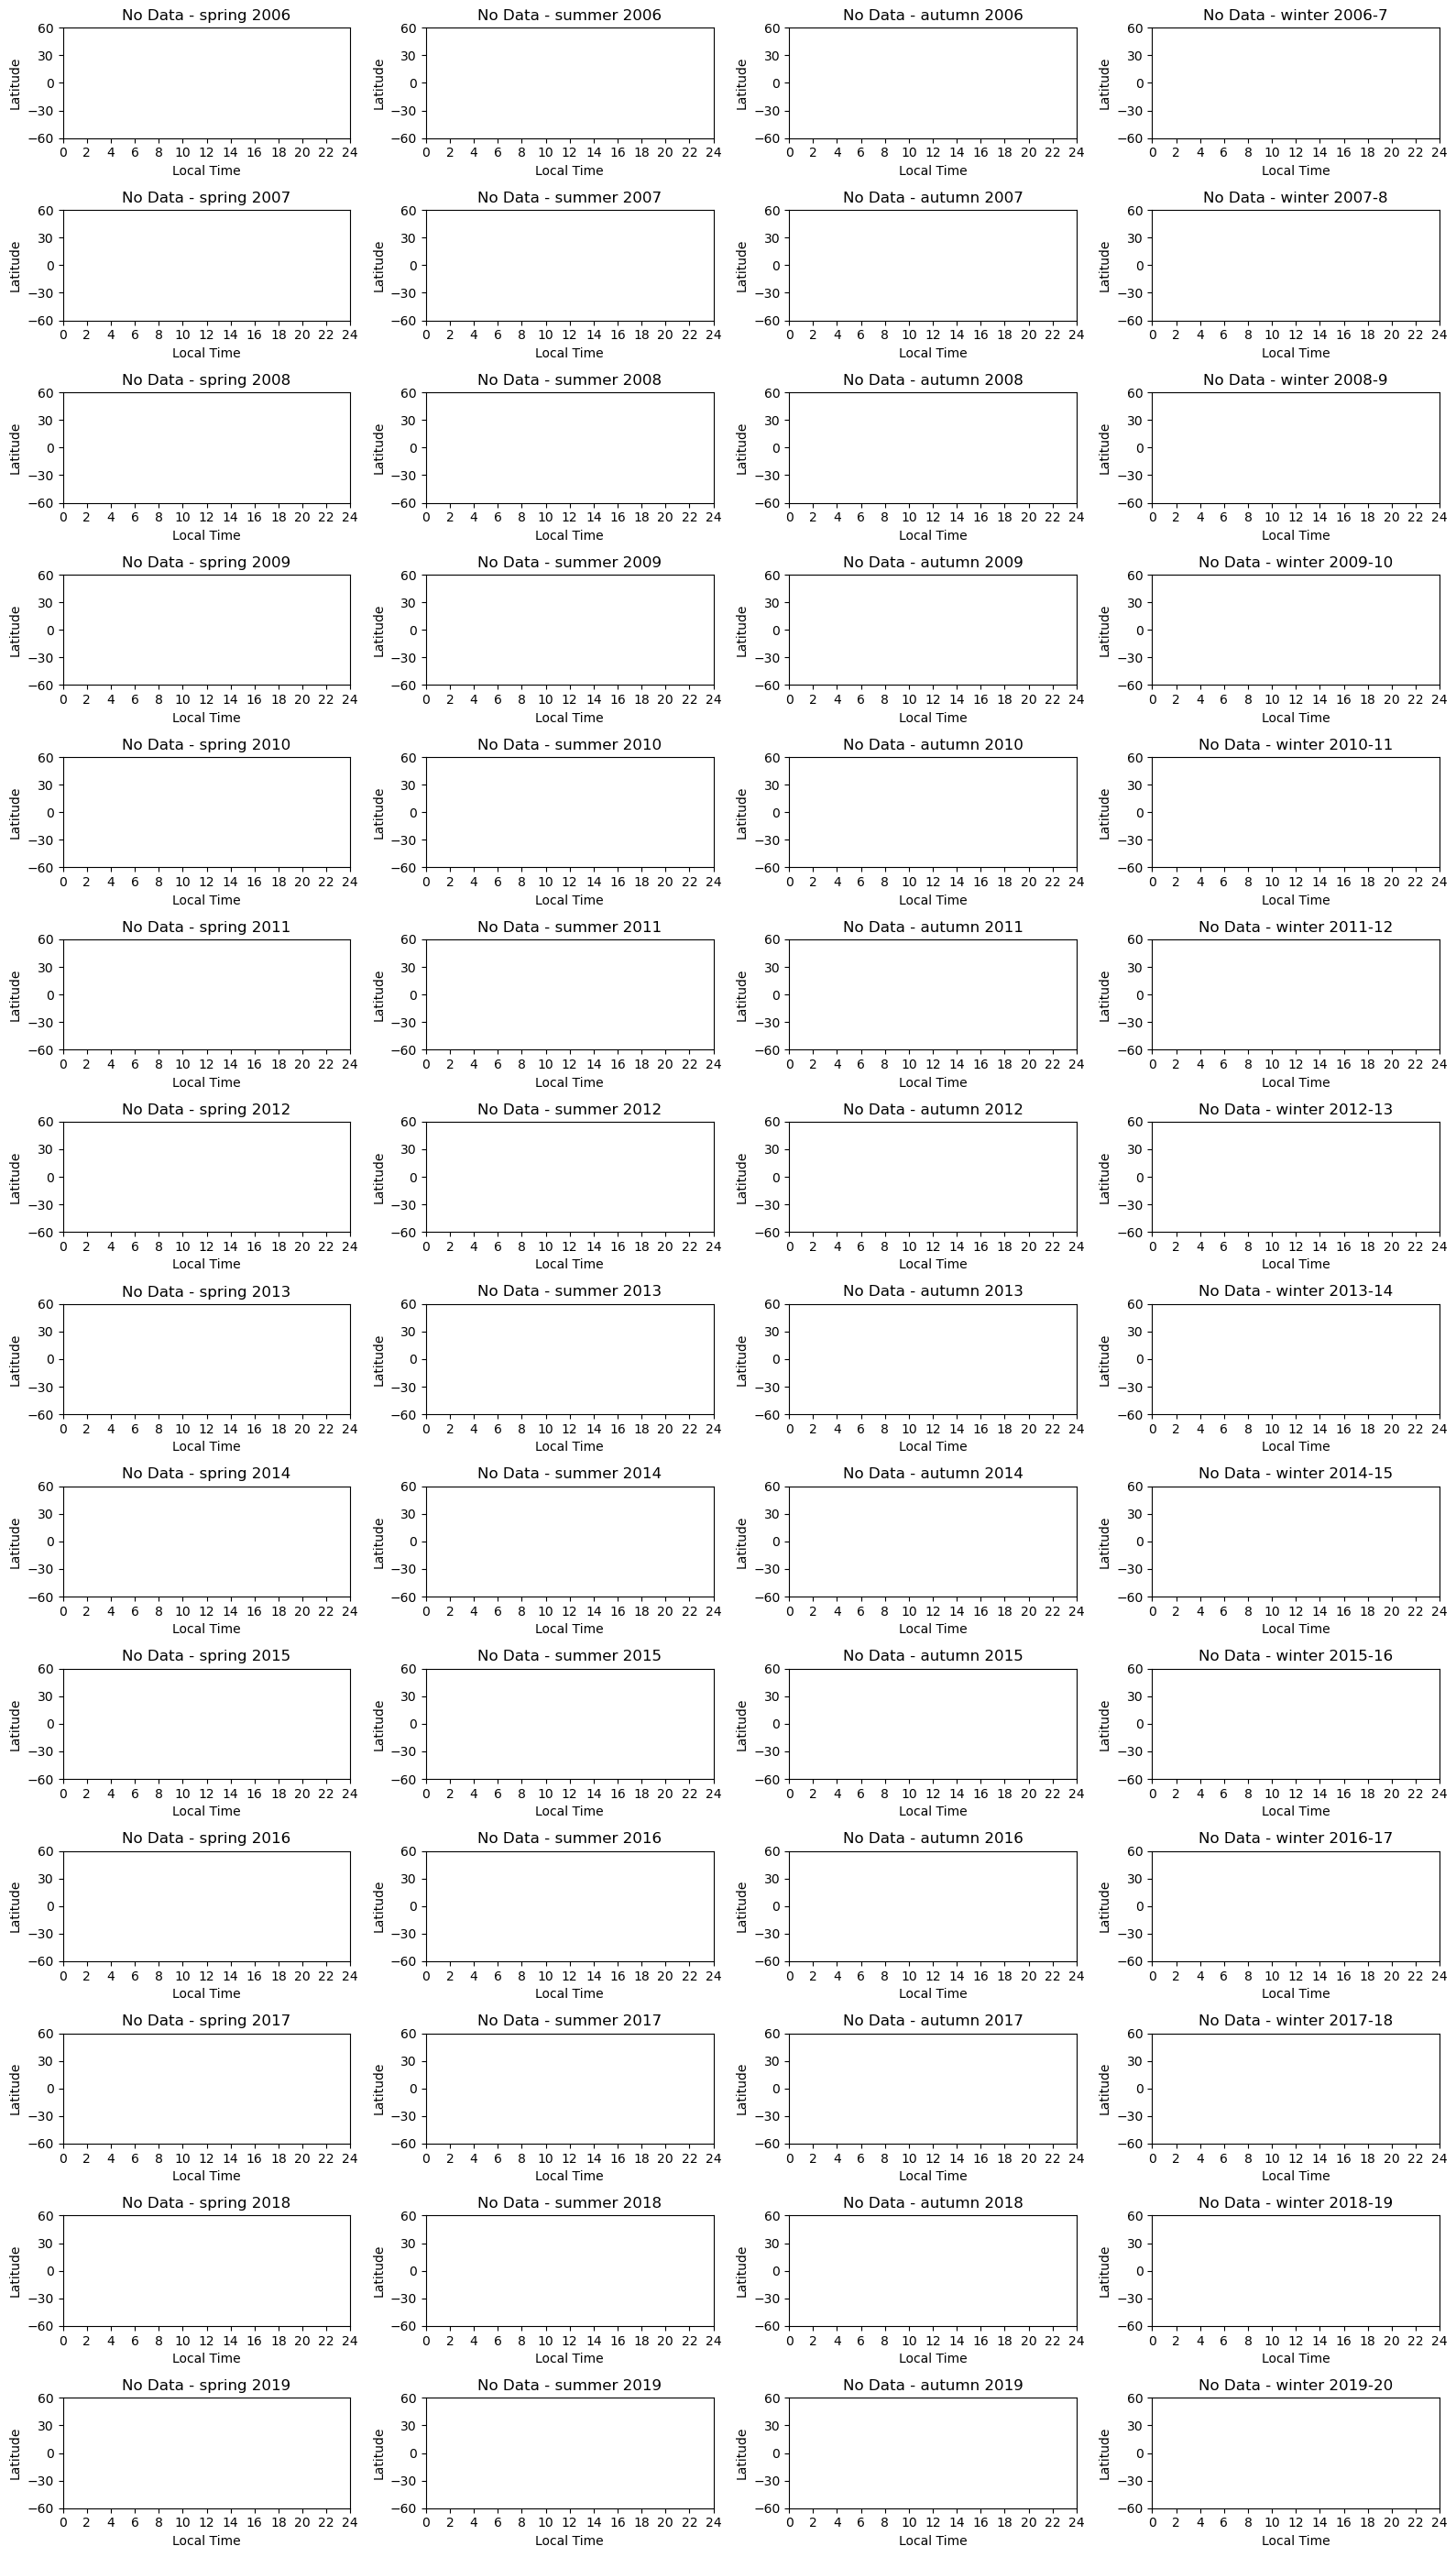

In [29]:
## PLOT nmeas_LT and freq_LT ##
# NOTE, will not work for fivedegbins=1 as there is only data for fivedegbins=0



cmap = plt.cm.jet
new_cmap = cmap(np.linspace(0, 1, 256))
new_cmap[0] = (0.5, 0.5, 0.5, 0.6)  # Set color for zero values to grey with transparency


# Define constants
vmin = 0
vmax = 180
nolevs = 19 #(vmax - vmin) +1

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/LT/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28))

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT.nc'
        else:
            if fivedegbins == 1:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc'
            else:
                file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT.nc'
                
                
        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            ltout = output_ds['local_time']
            ocfr_out = output_ds['ocfr_LT']
            nmeas_LT_out = output_ds['nmeas_LT']
            freq_LT_out = output_ds['freq_LT']
            
#             lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
#             latout_slice = latout[lat_indices]
#             ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(ltout, latout, nmeas_LT_out, cmap=colors.ListedColormap(new_cmap)
                                , levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                ,extend='both' )
            
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('Total Measurements')
            #cbar.set_label('# SpEs')

        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    xticks = np.linspace(0, 24, 13)
    ax.set_xticks(xticks)
    ax.set_xlabel('Local Time')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()


if fivedegbins == 1:
    figname = f'n_meas_latLT_years_seasons_5d.png'
else:
    figname = f'n_meas_latLT_years_seasons.png'
    
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


# COSMIC Data Processing: Inter-Year Standard Deviations (lat-**LT**) for each season

In [2]:
# Tried this as an alternative to the above on a lat-lon axis to see if it got different results. 
# Ultimately it shouldn't matter as the std devs are for the lat line plot where the occurrence frequencies are averaged over all dims other than latitude

# Standard Deviation over time (multiple years)
# Same years for EACH SEASON
# Currently not working for 5x5' bins

# Define seasons, years, and output directory
seasons = ['spring', 'summer', 'autumn', 'winter']

# Davids data goes from summer 06 to autumn 19 inclusive. 
# Chinese groups data went from spring 07 to aut 2013


years = [2007, 2008, 2009, 2013] 


file_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/LT/"

# Initialize an empty dataset to store standard deviations
std_dev_dataset = xr.Dataset()

# Loop through seasons
for season in seasons:
    # Initialize an empty dataset to store standard deviations
    std_dev_dataset = xr.Dataset()
    
    # Define a list to store datasets for each year
    datasets = []


    for year in years:
        # Define the file pattern
        if season == 'winter':
            yr_last_two_digits = str(int(str(year)[-2:]) + 1)
            file_pattern = f"{file_directory}Ocfr_Daviddata_{year}-{yr_last_two_digits}_{season}_LT.nc"
        else:
            file_pattern = f"{file_directory}Ocfr_Daviddata_{year}_{season}_LT.nc"

        # Open the dataset
        ocfr_ds = xr.open_dataset(file_pattern)

        # Add a 'time' coordinate representing the year
        ocfr_ds['time'] = xr.DataArray([year], dims='time', coords={'time': [year]})

        # Append the dataset to the list
        datasets.append(ocfr_ds)
    
    # Concatenate along the time dimension
    combined_ds = xr.concat(datasets, dim='time')

    # Calculate the standard deviation for ocfr_lon
    #std_dev_lon = combined_ds['ocfr_lon'].std(dim='time')
    std_dev_LT = combined_ds['ocfr_LT'].std(dim='time')

    # Add the standard deviations to the result dataset
    #std_dev_dataset[f'std_dev_ocfr_lon_{season}'] = std_dev_lon
    std_dev_dataset[f'std_dev_ocfr_LT_{season}'] = std_dev_LT


    output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/LT/"

    output_file = f"{output_directory}Ocfr_stddev_{season}_{str(years[0])[-2:]}-{str(years[1])[-2:]}-{str(years[2])[-2:]}-{str(years[3])[-2:]}.nc"
    
    try:
        std_dev_dataset.to_netcdf(output_file)
        print(f"File saved successfully: {output_file}")
    except Exception as e:
        print(f"Error saving the file: {e}")
    finally:
        std_dev_dataset.close()

NameError: name 'xr' is not defined

# COSMIC Data Processing: Occ Freq (**ALT**-lat-**LT**), Seasons 

In [ ]:
# Processing Normal Lat Lon coordinates
# Seasons separately
#======================================

yrs_period = '2007-2009_2013'
years = [2007, 2008, 2009, 2013]

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]
month_to_season = {
    (12, 1, 2): "winter",
    (3, 4, 5): "spring",
    (6, 7, 8): "summer",
    (9, 10, 11): "autumn" }

ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = month_to_season.get(tuple(desired_months), "unknown")
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    nmeas_LT = np.zeros((altavg_num_bins, lat_num_bins, LT_num_bins))

    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        #current_lon = flon.values[i]
        
        current_LT = local_times[i]
        time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
        
        current_s4max = fs4s.values[i]
        
        current_time = fdatetimes[i]
        current_month = current_time.month
        year_value = current_time.year
        
        current_hmEs = fhmEs.values[i]
        
        if current_month in desired_months and year_value in years:      
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            #lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1
            LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            
            # if current_hmEs == altavg_bin_edges[-1]:
            #                 alt_bin_index = len(altavg_bin_edges) - 2
                    
            if not np.isnan(current_s4max):
                alt_bin_index = np.digitize(current_hmEs, altavg_bin_edges) - 1
                nmeas_LT[alt_bin_index, lat_bin_index, LT_bin_index] += 1.

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "n_altlatLT": (['altitude','latitude', 'local_time'], nmeas_LT),
        },
        coords={
            "altitude": altavg_bin_midpoints,
            "latitude": lat_bin_midpoints,
            "local_time": LT_bin_midpoints,
        },
        attrs={
            'years': yrs_period,
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/seasons/altitude/"
    output_file = f"{output_directory}n_Daviddata_{yrs_period}_{season}_altlatLT.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}n_Daviddata_{yrs_period}_{season}_altlatLT_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################
